# Krigging

In [1]:
from all_imports import *

import _modules

%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

from pykrige.rk import RegressionKriging
import datetime as dt

from _modules.plotColors import *
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter, DayLocator

file_name: str = "_00-Krigging"
filepath_dir: str =os.path.join(r"C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report", file_name)

 ### test init### 


### Preprocessing

In [2]:
# -------------------------------------------------------------------------------------------
# Load the weather data into a coherent dataframe for each environmental variable
#
# -------------------------------------------------------------------------------------------

def LoadWeatherStationDataIntoDf(item: str, dirs: List[str] = []) -> pd.DataFrame:

    df_list = []
    for file_dir in dirs:
        filepaths, filenames = _modules.find_files_in_directory(file_dir, 'csv')
        
        for weather_file in filepaths:
            #print(weather_file)
            filename = os.path.basename(weather_file)
            station_name = filename.split('_')[1]
            df = pd.read_csv(weather_file)
            df = df[['Datetime', item]]
            df.rename(columns={item: f"{station_name}_{item}"}, inplace=True)

            df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%dT%H:%M:%S')
            df = df.drop_duplicates('Datetime') #Sure?
            df.set_index('Datetime', inplace=True)
            
            df_list.append(df)

    combined_df = pd.concat(df_list, axis=1, join='outer')
    combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
    return combined_df


dirs = [r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202401\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202402\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202403\EveryMinute']

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_relH_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)
WS_Rad_df = LoadWeatherStationDataIntoDf('GlobalRad Ave (W/m2)', dirs)
# WS_Wspeed_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)
# WS_WDir_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)

start_date = '2024-01-01'
end_date = '2024-03-15'
WS_Temp_filtered_df = WS_Temp_df.loc[start_date:end_date]
WS_relH_df_filtered_df = WS_relH_df.loc[start_date:end_date]
WS_Rad_df_filtered_df = WS_Rad_df.loc[start_date:end_date]
#display(WS_Temp_filtered_df.columns)


C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\431027251.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\431027251.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\431027251.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()


In [3]:
# -------------------------------------------------------------------------------------------
# Load the weather station data and adjust it to meters and compute the relevenant features
#
# -------------------------------------------------------------------------------------------

from pyproj import Proj, transform
from scipy.spatial.distance import cdist

parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirOut: str = r'Esse\report\krigging_output'

griddf = pd.read_csv(parent_dir + '5mGrid_features_updated.csv').fillna(0)

general           = ['X', 'Y', 'Lat', 'Lon', 'Shortname']
terrain_features  = ['Terrain_height']
sky_features      = ['BLDandVEG_Sun_h', 'BLDandVEG_SkyExp']
bld_features      = ['BLD_percent', 'BLD_Height']
veg_percentage    = ['VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent']
veg_distances     = ['VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']
distance_features = ['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance']


WS_df = pd.read_csv(os.path.join(parent_dir, 'WS_features_updated.csv'))
wgs84 = Proj(init='epsg:4326') 
utm = Proj(init='epsg:3414')   

def convert_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

WS_df['X'], WS_df['Y'] = convert_to_meters(WS_df['Lon'], WS_df['Lat'])


def add_closest_grid_info_multiple(WS_df, griddf, columns=[veg_percentage + veg_distances + bld_features + distance_features], num_closest=5):
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    closest_indices = np.argsort(distances, axis=1)[:, :num_closest]
    
    averaged_values = {col: [] for col in columns}
    
    for indices in closest_indices:
        closest_data = griddf.iloc[indices][columns]
        for col in columns:
            averaged_values[col].append(closest_data[col].mean())
    
    averaged_info = pd.DataFrame(averaged_values)
    
    WS_df = pd.concat([WS_df.reset_index(drop=True), averaged_info], axis=1)
    unique_reference_values = np.unique(closest_indices.flatten()).tolist()
    return WS_df, unique_reference_values


features = general + distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances
selection = distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances
modified_WS_df, reference_values = add_closest_grid_info_multiple(WS_df, griddf, columns=selection, num_closest=5)

print(reference_values)
# display(WS_df.head(10))
# display(griddf.head(10))

selected_rows = griddf.loc[reference_values]
new_df = pd.DataFrame(selected_rows)
def convert_to_lon_lat(x, y):
    lon, lat = transform(utm, wgs84, x, y)
    return lon, lat


new_df['Lon'], new_df['Lat'] = convert_to_lon_lat(new_df['X'], new_df['Y'])
griddf['Lon'], griddf['Lat'] = convert_to_lon_lat(griddf['X'], griddf['Y'])

#display(modified_WS_df.head(5))
print(modified_WS_df.columns)
display(modified_WS_df)


kriging_ws_df = modified_WS_df[features]

c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\192617378.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotc

[1176, 1177, 1345, 1346, 1347, 2310, 2499, 2500, 2501, 2692, 3056, 3253, 3254, 3255, 3454, 3887, 3888, 4080, 4081, 4082, 4094, 4095, 4096, 4289, 4290, 5135, 5136, 5354, 5355, 5576, 6215, 6216, 6217, 6440, 6441, 7039, 7278, 7279, 7541, 7542, 8346, 8347, 8634, 8635, 8930, 12028, 12029, 12030, 12371, 12372, 14237, 14583, 14584, 14930, 14931, 16311, 16616, 16617, 16660, 16661, 16967, 16968, 17011, 17012, 17320, 19310, 19311, 19312, 19526, 19527, 19528, 19662, 19663, 19877, 19878, 19949, 19950, 19951, 20013, 20303, 20304, 20365, 20366, 20367, 20721, 20800, 20801, 21064, 21065, 21066, 21157, 21158, 21159, 21424, 21425, 25532, 25533, 25886, 25887, 26231, 29185, 29186, 29515, 29516, 29837, 30770, 30771, 30907, 31069, 31070, 31071, 31201, 31202, 31488, 31489, 31861, 31862, 32134, 32135, 32404, 39378, 39379, 39610, 39611, 39843, 46839, 46840, 46841, 47064, 47065, 49087, 49158, 49310, 49311, 49312, 49382, 49383, 49534, 49605, 49606, 54351, 54352, 54486, 54566, 54567, 54702, 54703, 54782, 54919, 5

C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\192617378.py:64: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)
C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\192617378.py:64: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)


Number/file name in AWS  Reflected in Google Map to NUS President  \
0                        76                                         1   
1                        60                                         2   
2                        62                                         3   
3                         3                                         4   
4                        75                                         5   
5                        73                                         6   
6                        61                                         7   
7                        29                                         8   
8                        25                                         9   
9                        11                                        10   
10                        6                                        11   
11                       72                                        12   
12                       48                                        13   
13                       42                                        14   
14                       33                                        15   
15                       67                                        16   
16                       32                                        17   
17                       31                                        18   
18                        9                                        19   
19                       47                                        20   
20                       36                                        21   
21                       13                                        22   
22                       65                                        23   
23                       14                                        24   
24                       18                                        25   
25                       39                                        26   
26                       24                                        27   
27                       50                                        28   
28                       37                                        29   
29                       68                                        30   
30                       17                                        31   
31                       69                                        32   
32                       16                                        33   
33                       56                                        34   
34                       77                                        35   
35                       43                                        36   
36                       74                                        37   
37                       45                                        38   
38                       57                                        39   
39                       44                                        40   

               Type                                           Longname  \
0   Weather station                      Lamp post - CP2A in front E3A   
1   Weather station                              Roof - E1A upper roof   
2   Weather station                      Lamp post - in between E2-E1A   
3   Weather station                               Railing - E1 level 2   
4   Weather station                              Railing - next to EW1   
5   Weather station                                       Roof - SDE3    
6   Weather station                        Column - shelter next to E8   
7   Weather station        Lamp post - U-Turn in front of LKCNH Museum   
8   Weather station                         Lamp post - roundabout YIH   
9   Weather station                        Lamp post - bus stop NUS IT   
10  Weather station            Column - AS8 / bus stop Central Library   
11  Weather station                                         Roof - AS3   
12  Weather station                   Lamp post 

### Linecharts

In [4]:
### FILTER ALL DATA BY DAY! OR SHOW DAY AND NIGHT PLOT BELOW EACH OTHER?

### OR JUST ADD MEAN VALUES FOR DAY, STUDY PERIOD AND NIGHT?

In [5]:
def plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum):
    # Resample data to 1-hour intervals and calculate mean
    start_date = '2024-01-01'
    end_date = '2024-03-15'
    WS_Temp_df = WS_Temp_df.loc[start_date:end_date]

    df = WS_Temp_df.resample('1H').mean()

    # Calculating min, max, and mean values for each hour
    min_values = df.min(axis=1)
    max_values = df.max(axis=1)
    mean_values = df.mean(axis=1)

    # Creating a new DataFrame with these values
    stats_df = pd.DataFrame({
        'Time': df.index,
        'Min': min_values,
        'Max': max_values,
        'Mean': mean_values
    })

    # Resample data by day to get daily mean
    daily_mean_values = WS_Temp_df.resample('D').mean().mean(axis=1)

    # Plotting the data
    plt.figure(figsize=(14, 6))

    # Shading the area between min and max
    plt.fill_between(stats_df['Time'], stats_df['Min'], stats_df['Max'], color='grey', alpha=0.5, label='Min-Max Range', linewidth=0.01)

    plt.axvspan(pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'), color='grey', alpha=0.15, label='Study Period')

    plt.axvspan(pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'), color='grey', alpha=0.15, label='Study Period')

    # Plotting the mean values as a thin red line
    sns.lineplot(data=stats_df, x='Time', y='Mean', color=highlightColor, label='Mean (Hourly)', linewidth=1)

    # Plotting the daily mean values as a black line
    sns.lineplot(x=daily_mean_values.index, y=daily_mean_values, color='black', label='Mean (Daily)', linewidth=1)

    # Setting y-axis limits
    plt.ylim(minimum, maximum)

    # Formatting the x-axis to show dates in DD.MM format
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d.%m"))
    plt.gca().xaxis.set_major_locator(DayLocator(interval=3))

    # Removing the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Weather Station Data: Min, Max, and Mean')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()

    # Saving the plot
    if filepath_dir:
        filepath = os.path.join(filepath_dir, Name)
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()



Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_AirTemperature.png


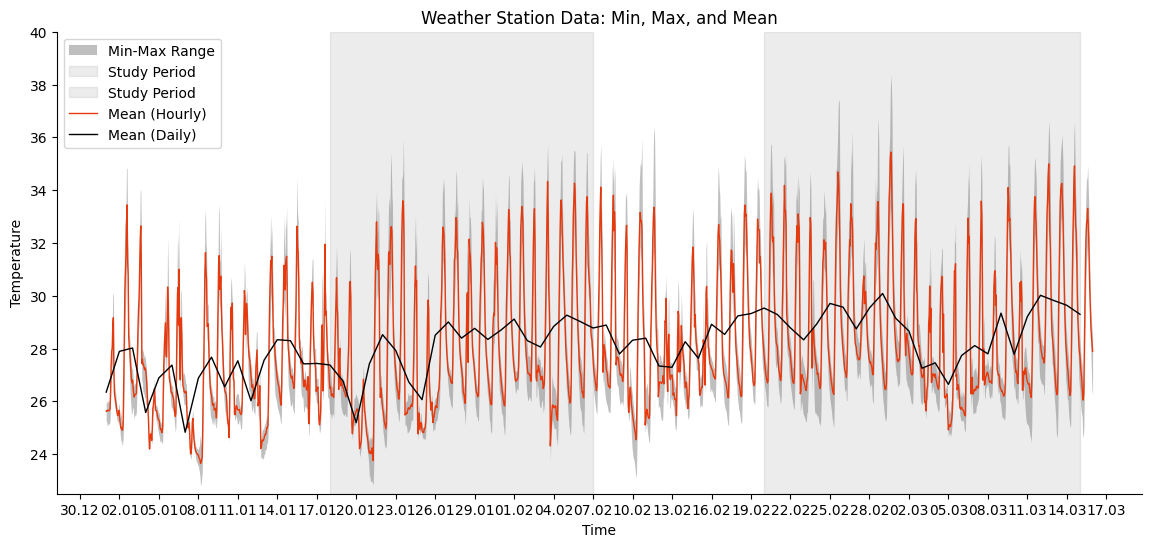

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_RelHumidity.png


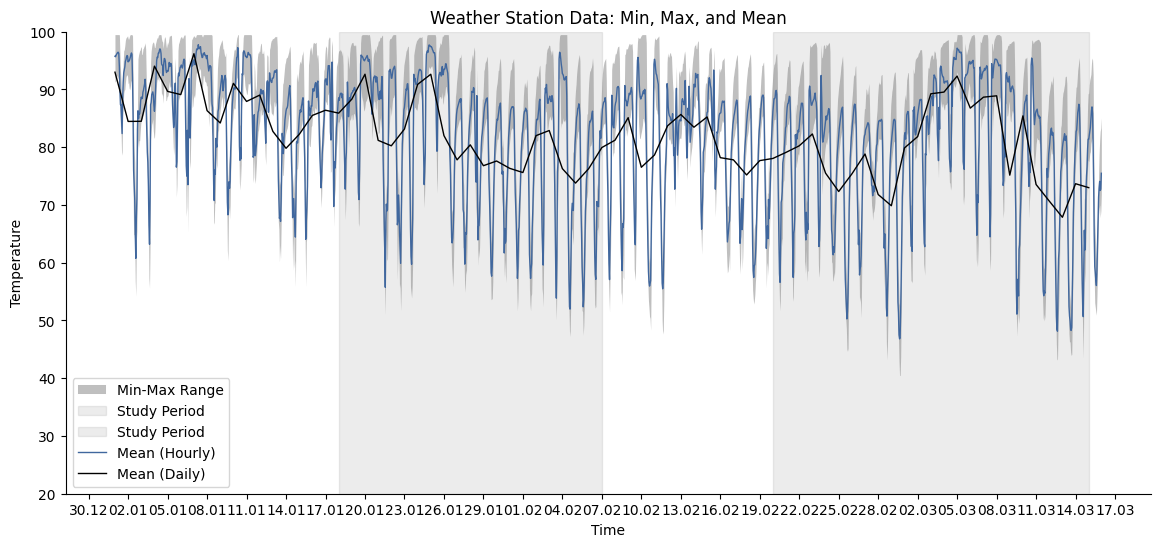

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_SolRadiation.png


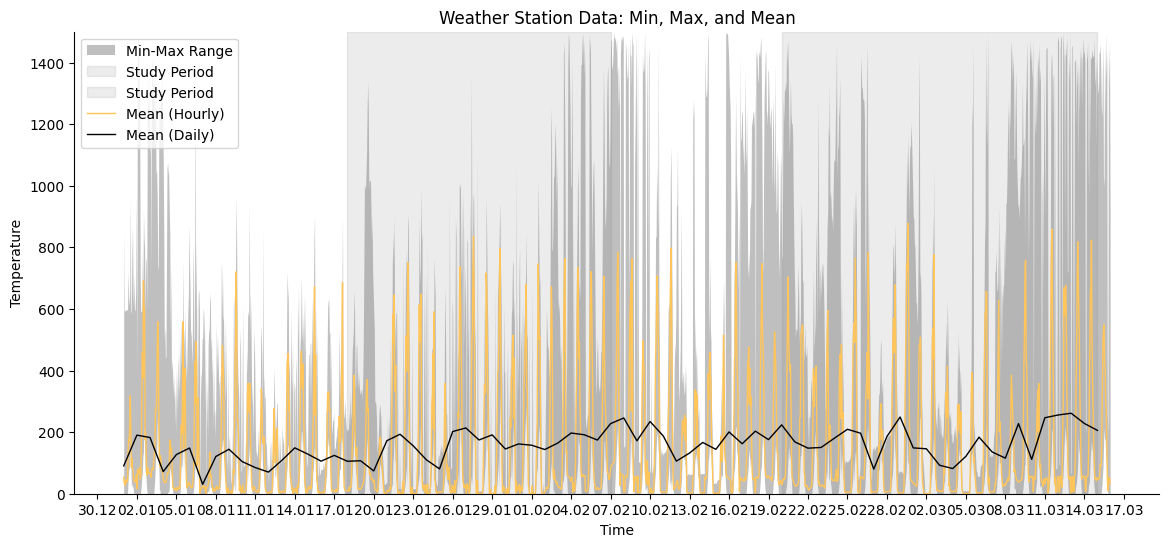

In [6]:
plot_weather_station_data(WS_Temp_df, filepath_dir, "Linechart_AirTemperature.png", color_vulcanfire, 22.5, 40)
plot_weather_station_data(WS_relH_df, filepath_dir, "Linechart_RelHumidity.png", cBlue, 20, 100)
plot_weather_station_data(WS_Rad_df, filepath_dir, "Linechart_SolRadiation.png", cYellow, 0, 1500)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.dates import DateFormatter, DayLocator

def plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum):
    # Resample data to 1-hour intervals and calculate mean
    start_date = '2024-01-01'
    end_date = '2024-03-15'
    df = WS_Temp_df.loc[start_date:end_date]
    
    #df = df.resample('6H').mean()

    # Resample data by day to get daily mean
    daily_mean_values = WS_Temp_df.resample('D').mean().mean(axis=1)

    # Plotting the data
    plt.figure(figsize=(14, 6))

    # Plotting all values as points

    for col in df.columns:
        sns.scatterplot(data=df, x=df.index, y=df[col], color='blue', alpha=0.3, label='_nolegend_', s=15)

    plt.axvspan(pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'), color='black', alpha=0.5, label='Study Period', hatch='/')

    plt.axvspan(pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'), color='black', alpha=0.5, hatch='/')

    # Plotting the daily mean values as a black line
    sns.lineplot(x=daily_mean_values.index, y=daily_mean_values, color='black', label='Mean (Daily)', linewidth=2)

    # Setting y-axis limits
    plt.ylim(minimum, maximum)

    # Formatting the x-axis to show dates in DD.MM format
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d.%m"))
    plt.gca().xaxis.set_major_locator(DayLocator(interval=3))

    # Removing the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Weather Station Data: All Values and Mean')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()

    # Saving the plot
    if filepath_dir:
        filepath = os.path.join(filepath_dir, Name)
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()


Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\test.png


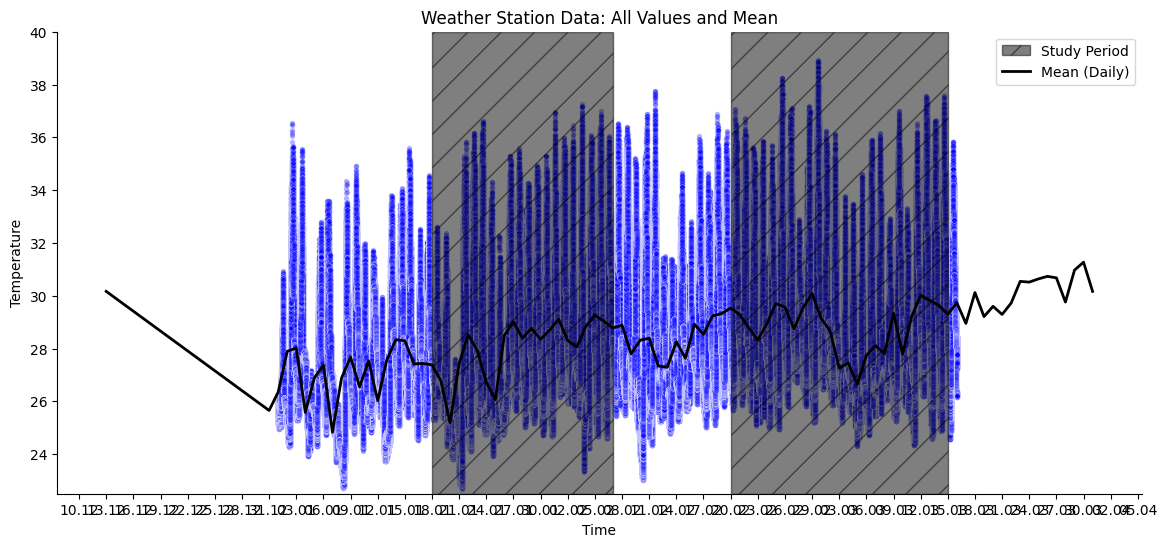

In [8]:
highlightColor = 'red'
minimum = 22.5
maximum = 40
Name = 'test.png'

plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum)

C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\2322101171.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Boxchart_AirTemperaturewithTotalValues_Day.png


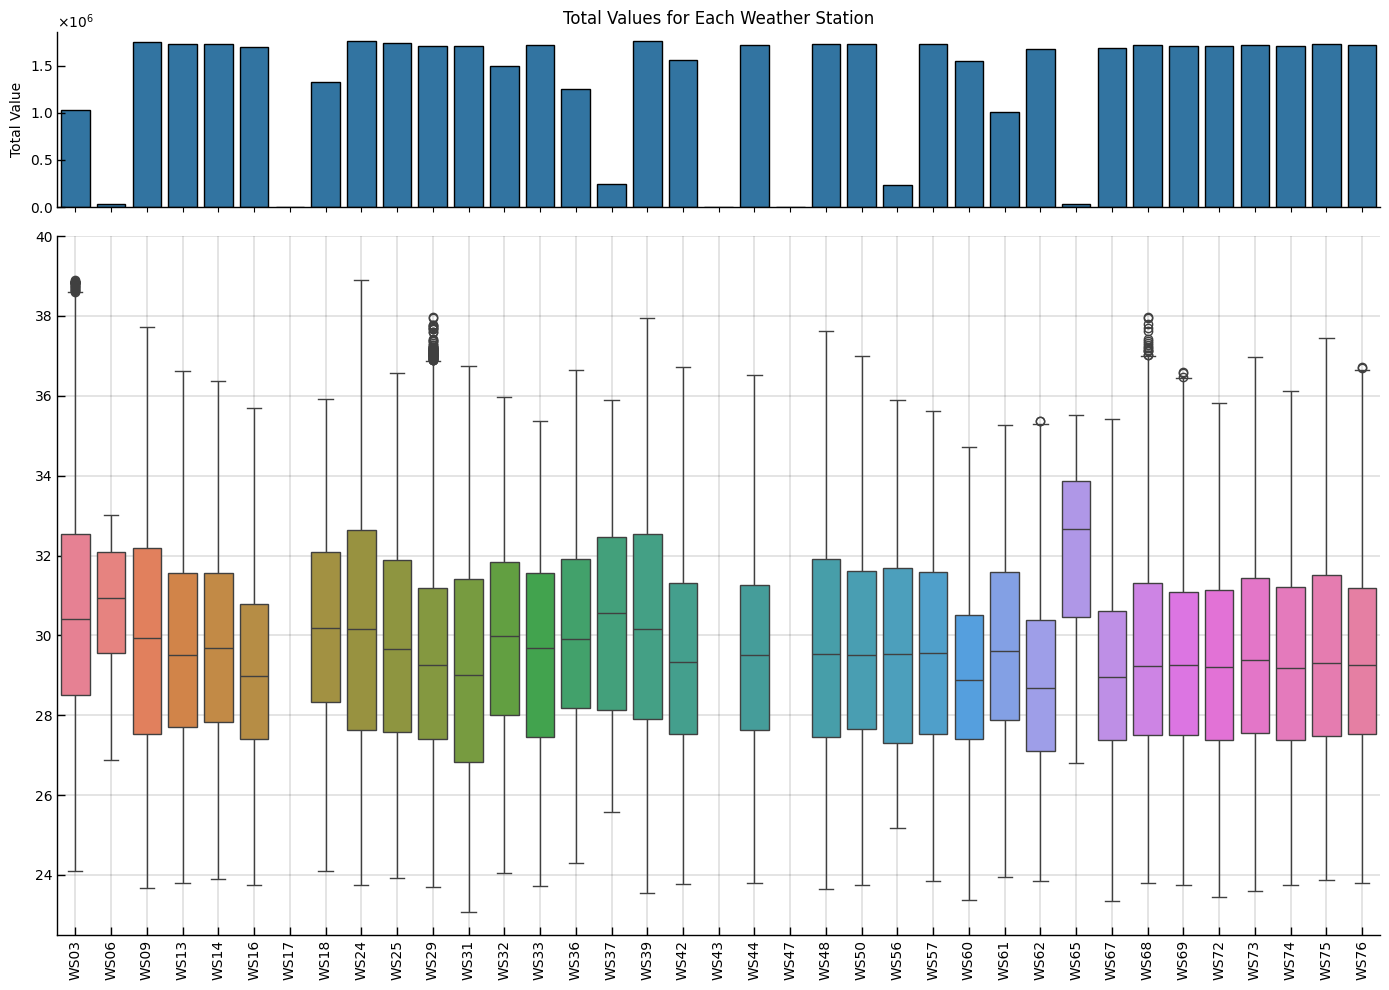

In [9]:
# -------------------------------------------------------------------------------------------
# Plot the boxplots
#
# -------------------------------------------------------------------------------------------

# Assume color_citylights, color_coralpink, color_vulcanfire, color_deepseablue, and color_elderberryblack are predefined color values.

# Filter based on the hour
filtered_df = WS_Temp_filtered_df[(WS_Temp_filtered_df.index.hour > 7) & (WS_Temp_filtered_df.index.hour < 21)]

# Optionally rename columns
filtered_df.columns = [col.split('_')[0] for col in filtered_df.columns]

df = filtered_df

# Calculate total values
total_values = df.sum()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 4]})

# Bar plot on the first axis
bar = sns.barplot(x=total_values.index, y=total_values.values, ax=ax1)

# Customize bar plot aesthetics
ax1.set_title('Total Values for Each Weather Station')
ax1.set_ylabel('Total Value')
ax1.set_facecolor('white')
ax1.set_xticklabels([])  # Remove x-tick labels
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_linewidth(1)
ax1.spines['left'].set_color('black')
ax1.tick_params(axis='y', direction='in', length=6, width=1, colors='black')

ax1.set_xlabel('')

# Add black outline to bars
for patch in ax1.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)  # Set black outline

ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Box plot on the second axis
box = sns.boxplot(data=df, ax=ax2)

# Customize box plot aesthetics
ax2.set_ylim(22.5, 40)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_facecolor('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_linewidth(1)
ax2.spines['left'].set_color('black')
fig.set_facecolor('white')
ax2.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax2.grid(True, which='both', axis='both', color='black', linestyle='-', linewidth=0.15)

# Adjust layout
plt.tight_layout()

# Show the plot
filepath = os.path.join(filepath_dir, "Boxchart_AirTemperaturewithTotalValues_Day.png")
if filepath != "":
    directory = os.path.dirname(filepath)
        
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
    print(f"Plot saved to {filepath}")

plt.show()


In [10]:
display(WS_Temp_filtered_df.describe())
display(WS_Rad_df_filtered_df.describe())
display(WS_relH_df_filtered_df.describe())

WS03_AirTemp Ave (C)  WS06_AirTemp Ave (C)  WS09_AirTemp Ave (C)  \
count          62357.000000           1713.000000         108000.000000   
mean              29.206778             29.349796             28.135418   
std                2.553112              2.025711              2.964813   
min               24.090000             25.670000             22.690000   
25%               27.350000             27.930000             25.930000   
50%               28.320000             28.900000             27.080000   
75%               30.680000             31.270000             30.250000   
max               38.900000             33.020000             37.720000   

       WS13_AirTemp Ave (C)  WS14_AirTemp Ave (C)  WS16_AirTemp Ave (C)  \
count         108000.000000         108000.000000         107937.000000   
mean              28.293832             28.260304             27.991551   
std                2.471868              2.449787              2.162928   
min               23.360000             23.750000             23.760000   
25%               26.610000             26.520000             26.530000   
50%               27.620000             27.530000             27.460000   
75%               29.800000             29.970000             29.240000   
max               36.620000             36.380000             35.690000   

       WS17_AirTemp Ave (C)  WS18_AirTemp Ave (C)  WS24_AirTemp Ave (C)  \
count                   0.0          81245.000000         108000.000000   
mean                    NaN             28.587211             28.343013   
std                     NaN              2.508688              3.083736   
min                     NaN             23.540000             22.730000   
25%                     NaN             26.720000             26.090000   
50%                     NaN             27.860000             27.250000   
75%                     NaN             30.450000             30.530000   
max                     NaN             35.930000             38.910000   

       WS25_AirTemp Ave (C)  ...  WS62_AirTemp Ave (C)  WS65_AirTemp Ave (C)  \
count         108000.000000  ...         107992.000000           1984.000000   
mean              28.239304  ...             27.752824             30.268936   
std                2.656337  ...              2.045228              2.824337   
min               23.210000  ...             23.760000             25.660000   
25%               26.320000  ...             26.380000             28.080000   
50%               27.420000  ...             27.220000             29.685000   
75%               29.980000  ...             28.950000             33.042500   
max               36.580000  ...             35.370000             35.510000   

       WS67_AirTemp Ave (C)  WS68_AirTemp Ave (C)  WS69_AirTemp Ave (C)  \
count         107902.000000         108000.000000         107988.000000   
mean              27.801930             28.214367             28.153727   
std                2.102444              2.442513              2.335041   
min               23.340000             23.660000             23.760000   
25%               26.320000             26.570000             26.590000   
50%               27.220000             27.550000             27.530000   
75%               29.210000             29.520000             29.500000   
max               35.420000             37.980000             36.600000   

       WS72_AirTemp Ave (C)  WS73_AirTemp Ave (C)  WS74_AirTemp Ave (C)  \
count         108000.000000         108000.000000         108000.000000   
mean              27.942134             28.159308             27.979184   
std                2.362530              2.469214              2.361207   
min               23.460000             23.590000             23.590000   
25%               26.270000             26.430000             26.340000   
50%               27.210000             27.410000             27.260000   
75%               29.510000             29.700000        

WS03_GlobalRad Ave (W/m2)  WS06_GlobalRad Ave (W/m2)  \
count               62327.000000                1713.000000   
mean                   75.554623                  78.476941   
std                   160.384105                 143.486431   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   1.000000   
75%                    83.000000                 112.000000   
max                  1096.000000                 821.000000   

       WS09_GlobalRad Ave (W/m2)  WS13_GlobalRad Ave (W/m2)  \
count              107982.000000              107649.000000   
mean                  162.093932                 139.884402   
std                   262.356410                 252.138608   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     1.000000                   3.000000   
75%                   245.000000                 175.000000   
max                  1369.000000                1405.000000   

       WS14_GlobalRad Ave (W/m2)  WS16_GlobalRad Ave (W/m2)  \
count              107986.000000              107923.000000   
mean                  170.100263                  82.029011   
std                   273.506964                 178.744798   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     1.000000                   1.000000   
75%                   256.000000                  83.000000   
max                  1390.000000                1248.000000   

       WS17_GlobalRad Ave (W/m2)  WS18_GlobalRad Ave (W/m2)  \
count                        0.0               81217.000000   
mean                         NaN                 180.911152   
std                          NaN                 288.030977   
min                          NaN                   0.000000   
25%                          NaN                   0.000000   
50%                          NaN                   1.000000   
75%                          NaN                 282.000000   
max                          NaN                1397.000000   

       WS24_GlobalRad Ave (W/m2)  WS25_GlobalRad Ave (W/m2)  ...  \
count              107954.000000              107978.000000  ...   
mean                  164.670591                 113.392571  ...   
std                   278.288680                 206.343090  ...   
min                     0.000000                   0.000000  ...   
25%                     0.000000                   0.000000  ...   
50%                     0.000000                   0.000000  ...   
75%                   234.000000                 143.000000  ...   
max                  1481.000000                1193.000000  ...   

       WS62_GlobalRad Ave (W/m2)  WS65_GlobalRad Ave (W/m2)  \
count              107979.000000                1984.000000   
mean                   78.171274                 143.723790   
std                   173.510376                 223.522484   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     1.000000                   0.000000   
75%                    73.000000                 254.250000   
max                  1144.000000                1170.000000   

       WS67_GlobalRad Ave (W/m2)  WS68_GlobalRad Ave (W/m2)  \
count              107903.000000              107988.000000   
mean                  163.823545                 102.147822   
std                   264.935838                 210.356224   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     1.000000                   2.000000   
75%                   249.000000                  98.000000   
max                  1359.000000                12

WS03_RelHum Ave (%)  WS06_RelHum Ave (%)  WS09_RelHum Ave (%)  \
count         62357.000000          1713.000000        108000.000000   
mean             78.328290            73.634267            80.649212   
std              11.915383             9.058164            12.999873   
min              38.100000            56.800000            39.600000   
25%              71.500000            67.500000            72.300000   
50%              81.900000            74.200000            85.100000   
75%              86.900000            81.700000            90.800000   
max              97.600000            90.000000            96.600000   

       WS13_RelHum Ave (%)  WS14_RelHum Ave (%)  WS16_RelHum Ave (%)  \
count        108000.000000        108000.000000        107937.000000   
mean             79.640703            81.737654            79.821682   
std              10.963464            10.842124            10.355673   
min              43.600000            44.400000            44.500000   
25%              72.900000            75.100000            74.100000   
50%              82.200000            85.000000            82.200000   
75%              87.300000            89.600000            87.000000   
max              96.900000            97.300000            97.300000   

       WS17_RelHum Ave (%)  WS18_RelHum Ave (%)  WS24_RelHum Ave (%)  \
count                  0.0         81245.000000        108000.000000   
mean                   NaN            80.979643            83.946466   
std                    NaN            12.105951            13.243894   
min                    NaN            44.800000            39.700000   
25%                    NaN            72.500000            75.100000   
50%                    NaN            84.000000            88.000000   
75%                    NaN            89.700000            94.200000   
max                    NaN            99.500000            99.500000   

       WS25_RelHum Ave (%)  ...  WS62_RelHum Ave (%)  WS65_RelHum Ave (%)  \
count        108000.000000  ...        107992.000000          1984.000000   
mean             83.735898  ...            84.088544            70.593145   
std              12.042715  ...             9.682888            11.261724   
min              44.300000  ...            48.300000            49.900000   
25%              76.200000  ...            78.700000            60.000000   
50%              87.000000  ...            86.600000            71.950000   
75%              93.100000  ...            91.000000            80.200000   
max              99.500000  ...            99.500000            89.600000   

       WS67_RelHum Ave (%)  WS68_RelHum Ave (%)  WS69_RelHum Ave (%)  \
count        107902.000000        108000.000000        107988.000000   
mean             78.723408            79.383563            79.543901   
std              10.073793            11.267079            10.999288   
min              43.700000            38.800000            42.600000   
25%              72.900000            73.200000            73.400000   
50%              81.600000            82.000000            82.000000   
75%              86.000000            87.300000            87.100000   
max              94.800000            96.400000            97.900000   

       WS72_RelHum Ave (%)  WS73_RelHum Ave (%)  WS74_RelHum Ave (%)  \
count        108000.000000        108000.000000        108000.000000   
mean             83.501606            79.002265            80.079700   
std              10.894330            11.553343            11.146459   
min              45.700000            39.500000            40.900000   
25%              76.900000            72.600000            73.600000   
50%              86.700000            82.500000            83.300000   
75%              91.600000            87.300000            88.200000   
max              99.300000            95.600000            95.600000   

       WS75_RelHum Ave (%)  WS76_RelHum Ave (%)  
count        10800

C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\3016489190.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return cumulative_counts_df.fillna(method='ffill').fillna(0)
C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\3016489190.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return cumulative_counts_df.fillna(method='ffill').fillna(0)
C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\3016489190.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return cumulative_counts_df.fillna(method='ffill').fillna(0)


Plot saved to your_filepath_here\FilteredCumulativeDataCounts_Subplots_Seaborn.png


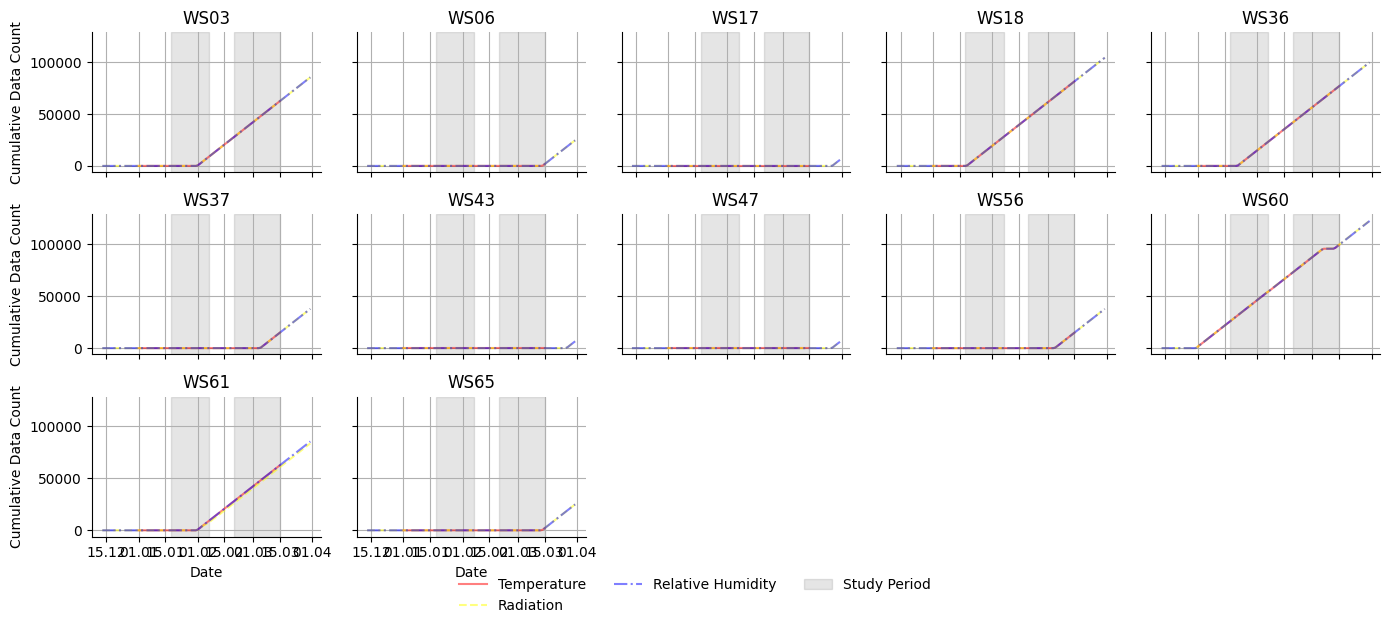

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import os

# Assume WS_Temp_filtered_df, WS_Rad_df, WS_relH_df are already defined and contain the filtered data

# Function to rename columns by splitting with '_' separator and taking the first part
def rename_columns(df):
    df.columns = [col.split('_')[0] for col in df.columns]
    return df

# Rename columns for each DataFrame
WS_Temp_filtered_df = rename_columns(WS_Temp_filtered_df)
WS_Rad_df = rename_columns(WS_Rad_df)
WS_relH_df = rename_columns(WS_relH_df)

# Function to compute cumulative counts DataFrame
def compute_cumulative_counts(df):
    availability_df = df.notna().astype(int)
    availability_df = availability_df.resample('D').sum().fillna(0)
    cumulative_counts_df = pd.DataFrame(index=availability_df.index)

    for station in availability_df.columns:
        cumulative_counts = availability_df[station].cumsum()
        cumulative_counts_df[station] = cumulative_counts

    return cumulative_counts_df.fillna(method='ffill').fillna(0)

# Compute cumulative counts for each DataFrame
cumulative_counts_temp_df = compute_cumulative_counts(WS_Temp_filtered_df)
cumulative_counts_rad_df = compute_cumulative_counts(WS_Rad_df)
cumulative_counts_relH_df = compute_cumulative_counts(WS_relH_df)

# Define the study period ranges
study_period_1 = (pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'))
study_period_2 = (pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'))

# Find stations with less than 80% valid data during the study periods
def find_stations_with_insufficient_data(df):
    valid_stations = []
    
    for station in df.columns:
        # Slice data for each study period
        data_study_period_1 = df.loc[study_period_1[0]:study_period_1[1], station]
        data_study_period_2 = df.loc[study_period_2[0]:study_period_2[1], station]
        
        # Check if less than 80% of the data is valid in either study period
        insufficient_data_study = (data_study_period_1.notna().mean() < 0.95) or (data_study_period_2.notna().mean() < 0.95)
        
        if insufficient_data_study:
            valid_stations.append(station)
    
    return valid_stations

# Find stations for each DataFrame that meet the criteria
insufficient_data_stations_temp = find_stations_with_insufficient_data(WS_Temp_filtered_df)
insufficient_data_stations_rad = find_stations_with_insufficient_data(WS_Rad_df)
insufficient_data_stations_relH = find_stations_with_insufficient_data(WS_relH_df)

# Filter cumulative counts DataFrames to include only those stations with insufficient data during study periods
filtered_cumulative_counts_temp_df = cumulative_counts_temp_df.loc[:, insufficient_data_stations_temp]
filtered_cumulative_counts_rad_df = cumulative_counts_rad_df.loc[:, insufficient_data_stations_rad]
filtered_cumulative_counts_relH_df = cumulative_counts_relH_df.loc[:, insufficient_data_stations_relH]

# Number of weather stations to plot
num_stations = len(filtered_cumulative_counts_temp_df.columns)

# Check if there are any stations with gaps
if num_stations > 0:
    # Define the number of columns per row
    cols_per_row = 5
    rows = int(np.ceil(num_stations / cols_per_row))

    # Create subplots
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(14, 2 * rows), sharex=True, sharey=True)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Date format for the x-axis
    date_format = mdates.DateFormatter('%d.%m')

    # Plot each filtered weather station's cumulative counts in its subplot using Seaborn
    for i, station in enumerate(filtered_cumulative_counts_temp_df.columns):
        ax = axes[i]

        # Plot Temperature data if exists
        sns.lineplot(x=filtered_cumulative_counts_temp_df.index, y=filtered_cumulative_counts_temp_df[station], ax=ax, linestyle='-', alpha=0.5, label='Temperature', legend=False, color='red')
        
        # Plot Radiation data if exists
        if station in filtered_cumulative_counts_rad_df.columns:
            sns.lineplot(x=filtered_cumulative_counts_rad_df.index, y=filtered_cumulative_counts_rad_df[station], ax=ax, linestyle='--', alpha=0.5, label='Radiation', legend=False, color='yellow')
        
        # Plot Relative Humidity data if exists
        if station in filtered_cumulative_counts_relH_df.columns:
            sns.lineplot(x=filtered_cumulative_counts_relH_df.index, y=filtered_cumulative_counts_relH_df[station], ax=ax, linestyle='-.', alpha=0.5, label='Relative Humidity', legend=False, color='blue')
        
        ax.set_title(station)
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Data Count')
        ax.grid(True)

        # Set the date format for x-axis
        ax.xaxis.set_major_formatter(date_format)

        # Add shaded regions to indicate study periods
        ax.axvspan(study_period_1[0], study_period_1[1], color='black', alpha=0.1, label='Study Period')
        ax.axvspan(study_period_2[0], study_period_2[1], color='black', alpha=0.1)

        # Hide the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Hide any unused subplots
    for j in range(num_stations, len(axes)):
        axes[j].axis('off')

    # Create a single legend at the bottom of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    filepath_dir = "your_filepath_here"  # Define the correct path
    filepath = os.path.join(filepath_dir, "FilteredCumulativeDataCounts_Subplots_Seaborn.png")
    
    if filepath != "":
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()
else:
    print("No weather stations have insufficient data during the study periods to plot.")


What do i need?

A Boxplot for each weather station, average, time of the day (night and day) and a linechart for the temperature path during the study
-- > this for each weatherstation as a layout plot

plot per average minute values, mazbe cluster the differnte stations based on environment

## Regression Kriging


In [12]:
# # OLD DEFINITIONS: Directory Definitions
# parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
# dirWH: str = os.path.join(parent_dir, 'Weatherdata')
# dirOut: str = r'Esse\report\krigging_output'

# # File Definitions
# griddf    = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)
# wsdf      = kriging_ws_df.drop(columns=['Lon', 'Lat']) #pd.read_csv(parent_dir + 'WS_features.csv').fillna(0) #whz is this 43 and not 38


# today = dt.datetime.now().strftime("%m%d%y-%H%M")
# print(today)


# #Load Files and make a feature selection
# #Feature selection
# terrain_features  = ['Ter_height']
# sky_features      = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx']
# bld_features      = ['Bld_percent', 'Bld_height']
# veg_features      = ['Veg_height', 'Veg_percent']
# distance_features = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad',  'distToPath', 'distToCourtTrack', 'distToCarpark']

# features = distance_features + sky_features   + veg_features  + bld_features + terrain_features

# display(griddf.head(5))
# display(wsdf.head(5))
# print(features)

In [13]:
# OLD DEFINITIONS: Directory Definitions
parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirWH: str = os.path.join(parent_dir, 'Weatherdata')
dirOut: str = r'Esse\report\krigging_output'

# File Definitions
griddf    = pd.read_csv(parent_dir + '5mGrid_features_updated.csv').fillna(0)
wsdf      = kriging_ws_df.drop(columns=['Lon', 'Lat']) #pd.read_csv(parent_dir + 'WS_features.csv').fillna(0) #whz is this 43 and not 38


today = dt.datetime.now().strftime("%m%d%y-%H%M")
print(today)


#Load Files and make a feature selection
#Feature selection
terrain_features  = ['Terrain_height']
sky_features      = ['BLDandVEG_Sun_h', 'BLDandVEG_SkyExp']
bld_features      = ['BLD_percent', 'BLD_Height']
veg_percentage    = ['VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent']
veg_distances     = ['VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']
distance_features = ['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance']

features = distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances

display(griddf.head(5))
display(wsdf.head(5))
wsdf.to_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\WS_features_computed.csv')

print(features)

082524-2201


id      X      Y  BLD_percent  BLD_distance  VEG_Shrub_distance  \
0  345  20858  30677          0.0     46.321287           96.600803   
1  346  20858  30672          0.0     43.719667           96.785652   
2  347  20858  30667          0.0     41.559078           97.227619   
3  348  20858  30662          0.0     39.911210           97.923221   
4  349  20858  30657          0.0     38.841375           98.644098   

   VEG_Shrub_percent  STREET_CarPark_percent  STREET_CarPark_distance  \
0                0.0                     0.0               118.056128   
1                0.0                     0.0               121.144543   
2                0.0                     0.0               124.357354   
3                0.0                     0.0               127.685169   
4                0.0                     0.0               131.119234   

   STREET_CourtTrack_percent  ...  VEG_TypeC_distance  VEG_TypeD_percent  \
0                        0.0  ...           40.265030              0.000   
1                        0.0  ...           39.059487              0.000   
2                        0.0  ...           38.470955              0.000   
3                        0.0  ...           38.415606              0.257   
4                        0.0  ...           38.527721              0.072   

   VEG_TypeD_distance  VEG_TypeE_percent  VEG_TypeE_distance  BLD_Height  \
0            1.854786                0.0           55.533746         0.0   
1            0.171425                0.0           54.312697         0.0   
2            0.148362                0.0           53.530857         0.0   
3            0.000000                0.0           53.031281         0.0   
4            0.000000                0.0           52.956058         0.0   

   VEG_Tree_Height  BLDandVEG_SkyExp  BLDandVEG_Sun_h  Terrain_height  
0              0.0         73.807908                8        5.884193  
1              0.0         73.895025                8        5.961543  
2              0.0         75.224961                9        5.971716  
3              0.0         76.611243                8        5.861810  
4              0.0         82.890209                8        5.751740  

[5 rows x 34 columns]

X             Y Shortname  STREET_CarPark_percent  \
0  21090.276586  31446.608220      WS76                  0.3502   
1  21018.301427  31316.750821      WS60                  0.0000   
2  21066.835035  31298.582162      WS62                  0.0000   
3  21039.589703  31247.486168      WS03                  0.0000   
4  21036.026652  31177.437049      WS75                  0.0000   

   STREET_CarPark_distance  STREET_CourtTrack_percent  \
0                 0.137760                        0.0   
1                26.368922                        0.0   
2                64.375464                        0.0   
3                54.972402                        0.0   
4                54.784100                        0.0   

   STREET_CourtTrack_distance  STREET_Path_percent  STREET_Path_distance  \
0                  121.954487                  0.0             21.895744   
1                  233.184419                  0.0             40.373938   
2                  205.803563                  0.0             91.251008   
3                  261.295745                  0.0             89.120003   
4                  319.048430                  0.0             20.861799   

   STREET_Road_percent  ...  BLD_percent  BLD_Height  Terrain_height  \
0               0.3112  ...        0.000    0.000000       24.996696   
1               0.0000  ...        0.290   16.540116       34.407831   
2               0.0000  ...        1.000    0.000000       37.547951   
3               0.4718  ...        0.548   38.268177       37.041089   
4               0.1048  ...        0.642   18.182040       35.557390   

   VEG_TypeA_distance  VEG_TypeB_distance  VEG_TypeC_distance  \
0            0.000000            2.669324            6.903046   
1           11.887889            2.106516            7.291730   
2           63.634202           44.561607           39.762896   
3           47.455893           47.535387           42.237677   
4           33.157814           25.756954           27.684181   

   VEG_TypeD_distance  VEG_TypeE_distance  VEG_Turf_distance  \
0            0.335490            4.882615           0.000000   
1           10.896521           15.883104           0.913160   
2           29.811385           28.945288           0.000000   
3            4.683099            3.951791           2.416046   
4           20.637183           26.025345          24.544936   

   VEG_Shrub_distance  
0           44.523452  
1           13.761093  
2            1.238752  
3           49.869348  
4           56.712319  

[5 rows x 33 columns]

['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance', 'BLDandVEG_Sun_h', 'BLDandVEG_SkyExp', 'VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent', 'BLD_percent', 'BLD_Height', 'Terrain_height', 'VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']


### Get the Weather Data to interpolate


In [14]:
### Specify temperature measure to use
import math
from datetime import timedelta

# GET COZIE DATA
participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])

participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['index_time'], format='mixed')
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_convert('Asia/Singapore')
# print(participant_data_local_df['index_time'].dtype) 
# display(participant_data_local_df['index_time']) 

participant_data_local_df = participant_data_local_df[
    participant_data_local_df['c_total_valid_data'] & 
    participant_data_local_df['c_longitude'].notnull()
]

df = participant_data_local_df[['index_time', 'id_participant','c_run_number', 'c_longitude', 'c_latitude']]

unique_run_numbers = df.groupby('id_participant')['c_run_number'].unique()
print(unique_run_numbers)

# Select data for id_participant = 'esse00' and c_run_number = 1
specific_data = df[
    (df['id_participant'] == 'esse02') & 
    (df['c_run_number'] != -1)
]

specific_data['index_time'] = specific_data['index_time'].dt.ceil('T')
index_time_list = specific_data['index_time'].tolist()

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_Temp_df.index = pd.to_datetime(WS_Temp_df.index).tz_localize('UTC').tz_convert('Asia/Singapore')
WS_Temp_df.columns = [col.split('_')[0] for col in WS_Temp_df.columns]
WS_df = WS_Temp_df.transpose()
reference_time_list = WS_df.columns

columns_to_keep = []

for index_time in index_time_list:
    closest_time = None
    min_diff = timedelta(minutes=3)

    for ref_time in reference_time_list:
        time_diff = abs(index_time - ref_time)
        if time_diff <= min_diff:
            closest_time = ref_time

    if closest_time is not None:
        columns_to_keep.append(closest_time)

# Remove duplicates and convert to list
columns_to_keep = list(set(columns_to_keep))

#print("Columns to keep:", columns_to_keep)

location_df = specific_data[['index_time', 'c_longitude', 'c_latitude', 'c_run_number', 'id_participant']] #'c_run_number'
location_df.set_index('index_time', inplace=True)
display(location_df)
location_df = location_df.drop(['c_run_number', 'id_participant'], axis=1)

selected_columns_df = WS_df[columns_to_keep].reset_index()
selected_columns_df.set_index('index', inplace=True)
selected_columns_df.index.name = 'Shortname'

measure_df = kriging_ws_df[['Lat', 'Lon', 'Shortname']]
#display(measure_df)

# Merge based on the 'Shortname' column
df = pd.merge(measure_df, selected_columns_df, on='Shortname', how='outer')
df = df.drop('Shortname', axis=1)
df = df.reset_index(inplace=False)
df.columns = df.columns.astype(str)

#display(df.head(2))
pprint(df.columns)



C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\2351891164.py:6: DtypeWarning: Columns (5,6,7,9,11,13,17,18,19,21,25,26,46,47,49,50,79,80,82,83,97) have mixed types. Specify dtype option on import or set low_memory=False.
  participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])


id_participant
esse00    [4.0, -1.0, 5.0, 6.0, 8.0, 11.0, 13.0, 15.0, 1...
esse01    [2.0, -1.0, 7.0, 11.0, 16.0, 18.0, 19.0, 21.0,...
esse02    [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 10.0...
esse03    [-1.0, 0.0, 1.0, 4.0, 8.0, 9.0, 12.0, 13.0, 14...
esse04    [-1.0, 9.0, 16.0, 18.0, 19.0, 21.0, 25.0, 26.0...
esse05    [-1.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 10.0...
esse06    [-1.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0...
esse07    [0.0, -1.0, 1.0, 2.0, 3.0, 5.0, 9.0, 10.0, 17....
esse08    [nan, 0.0, -1.0, 1.0, 2.0, 3.0, 5.0, 7.0, 8.0,...
esse09    [-1.0, 0.0, 1.0, 2.0, 4.0, 5.0, 8.0, 9.0, 16.0...
esse10    [-1.0, 1.0, 2.0, 3.0, 7.0, 9.0, 20.0, 21.0, 24...
esse11    [-1.0, 5.0, 13.0, 39.0, 55.0, 56.0, 62.0, 69.0...
esse13    [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 11.0...
esse14    [1.0, -1.0, 7.0, 14.0, 20.0, 22.0, 42.0, 44.0,...
Name: c_run_number, dtype: object


C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\2351891164.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_data['index_time'] = specific_data['index_time'].dt.ceil('T')
C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\431027251.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()


c_longitude  c_latitude  c_run_number  \
index_time                                                         
2024-02-20 10:26:00+08:00   103.770914    1.297225           0.0   
2024-02-20 10:51:00+08:00   103.771494    1.298664           0.0   
2024-02-20 10:51:00+08:00   103.771699    1.299204           0.0   
2024-02-20 11:01:00+08:00   103.773358    1.300284           0.0   
2024-02-20 11:38:00+08:00   103.780804    1.297369           1.0   
...                                ...         ...           ...   
2024-03-22 19:26:00+08:00   103.774246    1.292458          56.0   
2024-03-22 19:26:00+08:00   103.774246    1.292458          56.0   
2024-03-22 19:35:00+08:00   103.773939    1.291838          56.0   
2024-03-22 22:20:00+08:00   103.773130    1.300279          57.0   
2024-03-22 22:31:00+08:00   103.773368    1.300287          57.0   

                          id_participant  
index_time                                
2024-02-20 10:26:00+08:00         esse02  
2024-02-20 10:51:00+08:00         esse02  
2024-02-20 10:51:00+08:00         esse02  
2024-02-20 11:01:00+08:00         esse02  
2024-02-20 11:38:00+08:00         esse02  
...                                  ...  
2024-03-22 19:26:00+08:00         esse02  
2024-03-22 19:26:00+08:00         esse02  
2024-03-22 19:35:00+08:00         esse02  
2024-03-22 22:20:00+08:00         esse02  
2024-03-22 22:31:00+08:00         esse02  

[121 rows x 4 columns]

Index(['index', 'Lat', 'Lon', '2024-03-19 19:07:00+08:00',
       '2024-03-22 22:23:00+08:00', '2024-02-22 13:46:00+08:00',
       '2024-02-20 11:41:00+08:00', '2024-03-13 14:11:00+08:00',
       '2024-03-04 13:55:00+08:00', '2024-03-21 20:12:00+08:00',
       ...
       '2024-03-22 19:29:00+08:00', '2024-03-07 14:05:00+08:00',
       '2024-03-06 18:16:00+08:00', '2024-02-29 11:17:00+08:00',
       '2024-03-21 14:10:00+08:00', '2024-03-13 17:28:00+08:00',
       '2024-03-05 14:56:00+08:00', '2024-02-28 14:06:00+08:00',
       '2024-02-29 11:16:00+08:00', '2024-03-06 20:06:00+08:00'],
      dtype='object', length=111)


In [15]:
### Specify temperature measure to use
import math
from datetime import timedelta

# GET COZIE DATA
participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])

participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['index_time'], format='mixed')
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_convert('Asia/Singapore')
# print(participant_data_local_df['index_time'].dtype) 
# display(participant_data_local_df['index_time']) 

participant_data_local_df = participant_data_local_df[
    participant_data_local_df['c_total_valid_data'] & 
    participant_data_local_df['c_longitude'].notnull()
]

df = participant_data_local_df[['index_time', 'id_participant','c_run_number', 'c_longitude', 'c_latitude']]

unique_run_numbers = df.groupby('id_participant')['c_run_number'].unique()
print(unique_run_numbers)

# Select data for id_participant = 'esse00' and c_run_number = 1
specific_data = df[
    (df['id_participant'] == 'esse02') & 
    (df['c_run_number'] != -1)
]

specific_data['index_time'] = specific_data['index_time'].dt.ceil('T')
index_time_list = specific_data['index_time'].tolist()

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_Temp_df.index = pd.to_datetime(WS_Temp_df.index).tz_localize('UTC').tz_convert('Asia/Singapore')
WS_Temp_df.columns = [col.split('_')[0] for col in WS_Temp_df.columns]
WS_df = WS_Temp_df.transpose()
reference_time_list = WS_df.columns

columns_to_keep = []

for index_time in index_time_list:
    closest_time = None
    min_diff = timedelta(minutes=3)

    for ref_time in reference_time_list:
        time_diff = abs(index_time - ref_time)
        if time_diff <= min_diff:
            closest_time = ref_time

    if closest_time is not None:
        columns_to_keep.append(closest_time)

# Remove duplicates and convert to list
columns_to_keep = list(set(columns_to_keep))

print("Columns to keep:", columns_to_keep)

location_df = specific_data[['index_time', 'c_longitude', 'c_latitude']]
location_df.set_index('index_time', inplace=True)
display(location_df)

# Usage example
selected_columns_df = WS_df[columns_to_keep].reset_index()
selected_columns_df.set_index('index', inplace=True)
selected_columns_df.index.name = 'Shortname'

measure_df = kriging_ws_df[['Lat', 'Lon', 'Shortname']]
display(measure_df.describe())

# Merge based on the 'Shortname' column
df = pd.merge(measure_df, selected_columns_df, on='Shortname', how='outer')
df = df.drop('Shortname', axis=1)
df = df.reset_index(inplace=False)
df.columns = df.columns.astype(str)
# Fill NaN values with median of each column
# Skip non-numeric columns (like index or location columns)
# numeric_columns = df.select_dtypes(include=[np.number]).columns
# Calculate median for each numeric column
#medians = df.median()
# Fill NaN values with the median of each column
#df[numeric_columns] = df[numeric_columns].fillna(medians)
display(df.describe())

pprint(df.columns)


C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\2230226905.py:6: DtypeWarning: Columns (5,6,7,9,11,13,17,18,19,21,25,26,46,47,49,50,79,80,82,83,97) have mixed types. Specify dtype option on import or set low_memory=False.
  participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])


id_participant
esse00    [4.0, -1.0, 5.0, 6.0, 8.0, 11.0, 13.0, 15.0, 1...
esse01    [2.0, -1.0, 7.0, 11.0, 16.0, 18.0, 19.0, 21.0,...
esse02    [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 10.0...
esse03    [-1.0, 0.0, 1.0, 4.0, 8.0, 9.0, 12.0, 13.0, 14...
esse04    [-1.0, 9.0, 16.0, 18.0, 19.0, 21.0, 25.0, 26.0...
esse05    [-1.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 10.0...
esse06    [-1.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0...
esse07    [0.0, -1.0, 1.0, 2.0, 3.0, 5.0, 9.0, 10.0, 17....
esse08    [nan, 0.0, -1.0, 1.0, 2.0, 3.0, 5.0, 7.0, 8.0,...
esse09    [-1.0, 0.0, 1.0, 2.0, 4.0, 5.0, 8.0, 9.0, 16.0...
esse10    [-1.0, 1.0, 2.0, 3.0, 7.0, 9.0, 20.0, 21.0, 24...
esse11    [-1.0, 5.0, 13.0, 39.0, 55.0, 56.0, 62.0, 69.0...
esse13    [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 11.0...
esse14    [1.0, -1.0, 7.0, 14.0, 20.0, 22.0, 42.0, 44.0,...
Name: c_run_number, dtype: object


C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\2230226905.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_data['index_time'] = specific_data['index_time'].dt.ceil('T')
C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\431027251.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()


Columns to keep: [Timestamp('2024-03-19 19:07:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-22 22:23:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-22 13:46:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-20 11:41:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-13 14:11:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-04 13:55:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-21 20:12:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-28 13:38:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-06 19:57:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-07 13:04:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-06 18:02:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-05 12:41:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-11 16:30:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-07 18:17:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-19 07:17:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-08 19:41:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-05 

c_longitude  c_latitude
index_time                                        
2024-02-20 10:26:00+08:00   103.770914    1.297225
2024-02-20 10:51:00+08:00   103.771494    1.298664
2024-02-20 10:51:00+08:00   103.771699    1.299204
2024-02-20 11:01:00+08:00   103.773358    1.300284
2024-02-20 11:38:00+08:00   103.780804    1.297369
...                                ...         ...
2024-03-22 19:26:00+08:00   103.774246    1.292458
2024-03-22 19:26:00+08:00   103.774246    1.292458
2024-03-22 19:35:00+08:00   103.773939    1.291838
2024-03-22 22:20:00+08:00   103.773130    1.300279
2024-03-22 22:31:00+08:00   103.773368    1.300287

[121 rows x 2 columns]

Lat         Lon
count  40.000000   40.000000
mean    1.297436  103.775383
std     0.004432    0.003947
min     1.290103  103.770067
25%     1.294625  103.772357
50%     1.296968  103.774077
75%     1.299368  103.779307
max     1.308340  103.782631

index        Lat         Lon  2024-03-19 19:07:00+08:00  \
count  40.000000  40.000000   40.000000                  34.000000   
mean   19.500000   1.297436  103.775383                  32.379118   
std    11.690452   0.004432    0.003947                   1.040622   
min     0.000000   1.290103  103.770067                  30.870000   
25%     9.750000   1.294625  103.772357                  31.650000   
50%    19.500000   1.296968  103.774077                  32.220000   
75%    29.250000   1.299368  103.779307                  32.807500   
max    39.000000   1.308340  103.782631                  35.180000   

       2024-03-22 22:23:00+08:00  2024-02-22 13:46:00+08:00  \
count                  33.000000                  30.000000   
mean                   33.704848                  26.698333   
std                     0.749263                   0.320378   
min                    32.290000                  25.770000   
25%                    33.250000                  26.510000   
50%                    33.690000                  26.745000   
75%                    34.020000                  26.935000   
max                    35.250000                  27.230000   

       2024-02-20 11:41:00+08:00  2024-03-13 14:11:00+08:00  \
count                  30.000000                  31.000000   
mean                   27.031667                  26.298065   
std                     0.259935                   0.447813   
min                    26.360000                  24.620000   
25%                    26.852500                  26.075000   
50%                    27.085000                  26.430000   
75%                    27.190000                  26.575000   
max                    27.470000                  26.930000   

       2024-03-04 13:55:00+08:00  2024-03-21 20:12:00+08:00  ...  \
count                  30.000000                  34.000000  ...   
mean                   26.452667                  32.817941  ...   
std                     0.312001                   0.794057  ...   
min                    25.600000                  31.320000  ...   
25%                    26.265000                  32.300000  ...   
50%                    26.580000                  32.825000  ...   
75%                    26.635000                  33.277500  ...   
max                    26.940000                  34.650000  ...   

       2024-03-22 19:29:00+08:00  2024-03-07 14:05:00+08:00  \
count                  33.000000                  32.000000   
mean                   32.329697                  26.509687   
std                     0.893317                   0.229902   
min                    30.520000                  26.030000   
25%                    31.820000                  26.377500   
50%                    32.180000                  26.520000   
75%                    32.910000                  26.697500   
max                    34.470000                  26.860000   

       2024-03-06 18:16:00+08:00  2024-02-29 11:17:00+08:00  \
count                  32.000000                  30.000000   
mean                   30.708125                  26.721667   
std                     1.258413                   0.355383   
min                    28.790000                  25.610000   
25%                    29.612500                  26.507500   
50%                    30.680000                  26.815000   
75%                    31.780000                  26.957500   
max                    33.330000                  27.460000   

       2024-03-21 14:10:00+08:00  2024-03-13 17:28:00+08:00  \
count                  34.000000                  31.000000   
mean                   27.302941                  29.639355   
std                     0.353712                   1.087075   
min                    25.970000                  28.160000   
25%                    27.165000                  28.760000   
50%                    27.350000                  29.420000   
75%                    27.560000                  30.1

Index(['index', 'Lat', 'Lon', '2024-03-19 19:07:00+08:00',
       '2024-03-22 22:23:00+08:00', '2024-02-22 13:46:00+08:00',
       '2024-02-20 11:41:00+08:00', '2024-03-13 14:11:00+08:00',
       '2024-03-04 13:55:00+08:00', '2024-03-21 20:12:00+08:00',
       ...
       '2024-03-22 19:29:00+08:00', '2024-03-07 14:05:00+08:00',
       '2024-03-06 18:16:00+08:00', '2024-02-29 11:17:00+08:00',
       '2024-03-21 14:10:00+08:00', '2024-03-13 17:28:00+08:00',
       '2024-03-05 14:56:00+08:00', '2024-02-28 14:06:00+08:00',
       '2024-02-29 11:16:00+08:00', '2024-03-06 20:06:00+08:00'],
      dtype='object', length=111)


In [16]:
times = [col for col in df.columns if col not in ['index', 'Lat', 'Lon']]

index_list_str = [
    dt.strftime('%Y-%m-%d %H:%M:%S') + dt.strftime('%z')[:3] + ':' + dt.strftime('%z')[3:]
    for dt in location_df.index
]

# Convert list to string representation
# index_list_str = str(index_list_str)

print(len(times))
pprint(times)
# print(index_list_str)
# times = index_list_str

108
['2024-03-19 19:07:00+08:00',
 '2024-03-22 22:23:00+08:00',
 '2024-02-22 13:46:00+08:00',
 '2024-02-20 11:41:00+08:00',
 '2024-03-13 14:11:00+08:00',
 '2024-03-04 13:55:00+08:00',
 '2024-03-21 20:12:00+08:00',
 '2024-02-28 13:38:00+08:00',
 '2024-03-06 19:57:00+08:00',
 '2024-03-07 13:04:00+08:00',
 '2024-03-06 18:02:00+08:00',
 '2024-03-05 12:41:00+08:00',
 '2024-03-11 16:30:00+08:00',
 '2024-03-07 18:17:00+08:00',
 '2024-03-19 07:17:00+08:00',
 '2024-03-08 19:41:00+08:00',
 '2024-03-05 14:49:00+08:00',
 '2024-03-05 12:32:00+08:00',
 '2024-03-22 07:28:00+08:00',
 '2024-03-06 13:17:00+08:00',
 '2024-02-22 17:29:00+08:00',
 '2024-03-13 14:01:00+08:00',
 '2024-02-20 21:50:00+08:00',
 '2024-03-21 18:22:00+08:00',
 '2024-03-04 16:06:00+08:00',
 '2024-03-05 20:13:00+08:00',
 '2024-03-21 18:37:00+08:00',
 '2024-03-22 22:34:00+08:00',
 '2024-03-06 19:58:00+08:00',
 '2024-03-07 13:20:00+08:00',
 '2024-03-04 12:00:00+08:00',
 '2024-03-21 20:27:00+08:00',
 '2024-02-20 10:54:00+08:00',
 '2024

### Clustering

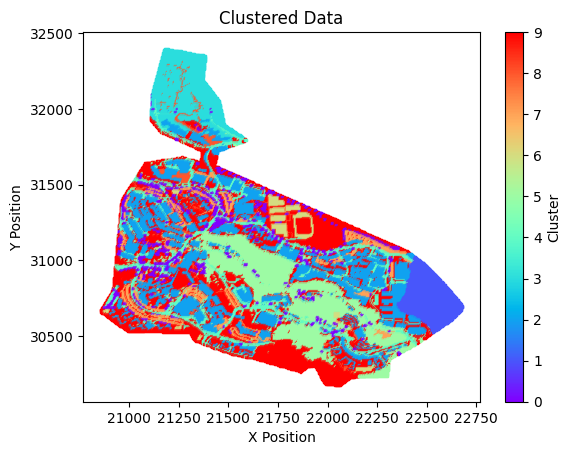

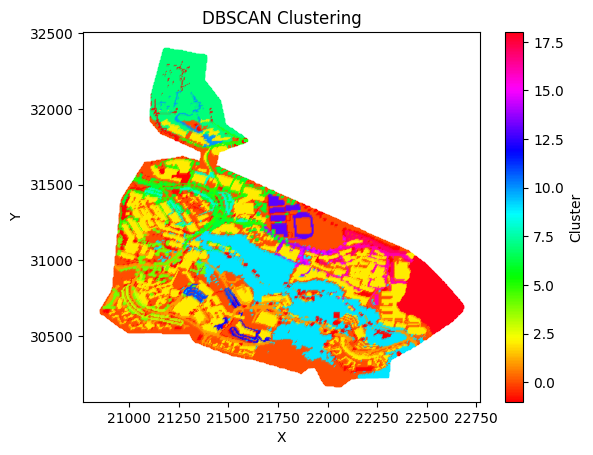

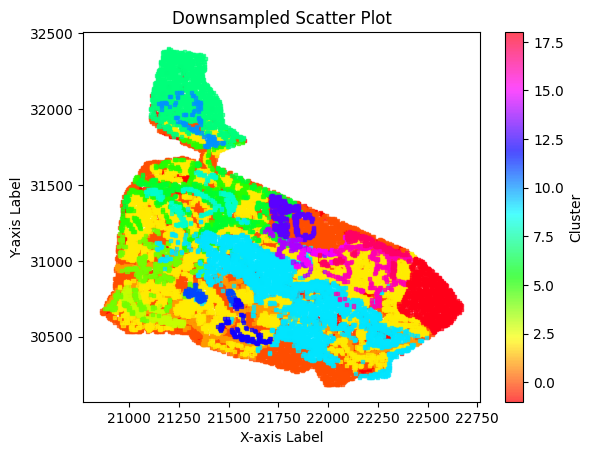

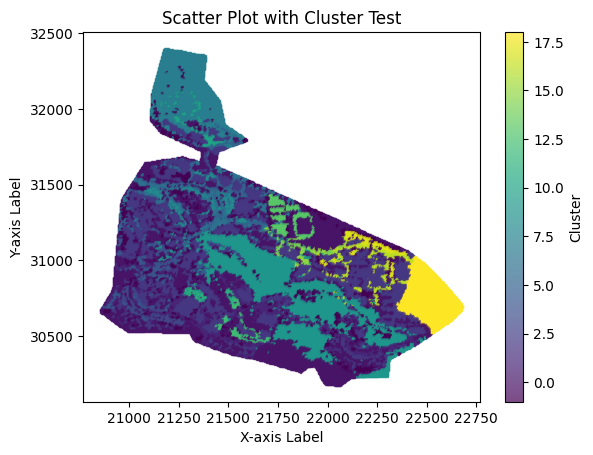

['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance', 'BLDandVEG_Sun_h', 'BLDandVEG_SkyExp', 'VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent', 'BLD_percent', 'BLD_Height', 'Terrain_height', 'VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance', 'cluster']


In [17]:
metadatadf = griddf.copy()

# Quantization function
def quantize_column(column, step_size):
    return round(column / step_size) * step_size

# Number of steps for quantization
num_steps = 3

feature_list = distance_features + veg_percentage  + bld_features + terrain_features + veg_distances


# Determine step sizes for each column and apply quantization
for col in feature_list:
    step_size = metadatadf[col].max() / num_steps
    metadatadf[f'quantized_{col}'] = metadatadf[col].apply(quantize_column, args=(step_size,))

# Standard scaling
scaler = StandardScaler()
metadatadf[feature_list] = scaler.fit_transform(metadatadf[feature_list])

# KMeans clustering
n_clusters = 10
metadatadf['cluster'] = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(metadatadf[feature_list])

# Plot the clustered data
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='rainbow', s=1, marker='s')
plt.title('Clustered Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.colorbar(label='Cluster')
plt.show()

#-------------------------------------------------------------------------------------------------
# DBSCAN clustering
X = metadatadf[['cluster', 'X', 'Y']] #features for DBclustering
X_scaled = StandardScaler().fit_transform(X)

eps = 0.30
min_samples = 250
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
metadatadf['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the DBSCAN clustering
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='hsv', s=1, marker='s')
plt.colorbar(label='Cluster')
plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


#-------------------------------------------------------------------------------------------------
#downsampling and upscaling again
# Group by the cluster column
metadata_df_grp = metadatadf.groupby('cluster')

# Define a function to sample a specific percentage from each group
def downsample_group(group):
    return group.sample(frac=0.25)  # You can adjust the fraction as needed

# Apply the downsampling function to each group
downsampled_df = metadata_df_grp.apply(downsample_group)

# Reset the index of the downsampled DataFrame
downsampled_df.reset_index(drop=True, inplace=True)

plt.scatter(downsampled_df['X'], downsampled_df['Y'], c=downsampled_df['cluster'], cmap='hsv', alpha=0.7,  s=5, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Downsampled Scatter Plot')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

# Fit Nearest Neighbors model on the downsampled data
nn_model = NearestNeighbors(n_neighbors=1).fit(downsampled_df[['X', 'Y']])

# Find the index of the nearest neighbor for each point in griddf
distances, indices = nn_model.kneighbors(griddf[['X', 'Y']])

# Map the cluster values from downsampled_df to griddf based on the nearest neighbors
griddf['cluster'] = downsampled_df.loc[indices.flatten()]['cluster'].values

plt.scatter(griddf['X'], griddf['Y'], c=griddf['cluster'], cmap='viridis', alpha=0.7,  s=1, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Cluster Test')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

#-------------------------------------------------------------------------------------------------
#Somehow smooth the data..



#-------------------------------------------------------------------------------------------------
#adjusting the considered features
quantized_cols = metadatadf.filter(like='quantized').columns
# griddf = metadatadf.drop(columns=quantized_cols) #.drop(columns=['cluster_x', 'cluster_y'])

features.append('cluster')

### get features for wsdf
# Calculating distances using sklearn's NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(griddf[['X', 'Y']])
distances, indices = nbrs.kneighbors(wsdf[['X', 'Y']])
# Add the index of the closest point in griddf to wsdf
wsdf['closest_index'] = indices.flatten()
# Retrieve specific columns from griddf based on closest_index and merge it with wsdf and only new selection features
merged_data = wsdf.join(griddf['cluster'], on='closest_index') #rsuffix='_griddf')
# Drop the redundant 'closest_index' column
wsdf = merged_data.drop(columns=['closest_index'])


# Print the updated list
print(features)

#display(griddf)


### Visualize Features

In [18]:
def plot_heatmaps(dataframe, feature_list, cmap_list, n_cols=3, filepath_dir: str = 'test', filename: str = 'example.png'):
    """
    Plot heatmaps for the specified features in the given DataFrame using the provided colormaps.

    Parameters:
    - dataframe: pd.DataFrame containing the data
    - feature_list: List of column names to plot as features
    - cmap_list: List of colormaps to use for each feature
    - n_cols: Number of columns in the subplot grid (default is 3)
    """
    # Ensure no duplicate entries by averaging duplicates
    dataframe = dataframe.groupby(['X', 'Y'], as_index=False).mean()

    # Define number of rows for the subplot grid
    n_rows = (len(feature_list) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4), constrained_layout=True)

    for i, (feature, cmap) in enumerate(zip(feature_list, cmap_list)):
        ax = axes[i // n_cols, i % n_cols]
        
        # Reshape data into a grid
        x_unique = np.sort(dataframe['X'].unique())
        y_unique = np.sort(dataframe['Y'].unique())
        X, Y = np.meshgrid(x_unique, y_unique)
        Z = dataframe.pivot(index='Y', columns='X', values=feature).values

        # Plot heatmap
        c = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
        fig.colorbar(c, ax=ax)
        ax.set_title(f'Heatmap of {feature}')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.grid(False)

    # Remove any unused subplots
    if len(feature_list) < n_rows * n_cols:
        for j in range(len(feature_list), n_rows * n_cols):
            fig.delaxes(axes.flatten()[j])

    filepath = os.path.join(filepath_dir, filename)
    if filepath != "":
        directory = os.path.dirname(filepath)
            
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")


    plt.savefig(filepath)

    plt.show()

id      X      Y  BLD_percent  BLD_distance  VEG_Shrub_distance  \
0  345  20858  30677          0.0     46.321287           96.600803   
1  346  20858  30672          0.0     43.719667           96.785652   
2  347  20858  30667          0.0     41.559078           97.227619   
3  348  20858  30662          0.0     39.911210           97.923221   
4  349  20858  30657          0.0     38.841375           98.644098   

   VEG_Shrub_percent  STREET_CarPark_percent  STREET_CarPark_distance  \
0                0.0                     0.0               118.056128   
1                0.0                     0.0               121.144543   
2                0.0                     0.0               124.357354   
3                0.0                     0.0               127.685169   
4                0.0                     0.0               131.119234   

   STREET_CourtTrack_percent  ...  VEG_TypeD_percent  VEG_TypeD_distance  \
0                        0.0  ...              0.000            1.854786   
1                        0.0  ...              0.000            0.171425   
2                        0.0  ...              0.000            0.148362   
3                        0.0  ...              0.257            0.000000   
4                        0.0  ...              0.072            0.000000   

   VEG_TypeE_percent  VEG_TypeE_distance  BLD_Height  VEG_Tree_Height  \
0                0.0           55.533746         0.0              0.0   
1                0.0           54.312697         0.0              0.0   
2                0.0           53.530857         0.0              0.0   
3                0.0           53.031281         0.0              0.0   
4                0.0           52.956058         0.0              0.0   

   BLDandVEG_SkyExp  BLDandVEG_Sun_h  Terrain_height  cluster  
0         73.807908                8        5.884193        0  
1         73.895025                8        5.961543        0  
2         75.224961                9        5.971716        0  
3         76.611243                8        5.861810        0  
4         82.890209                8        5.751740        0  

[5 rows x 35 columns]

Plot saved to your_filepath_here\features_01


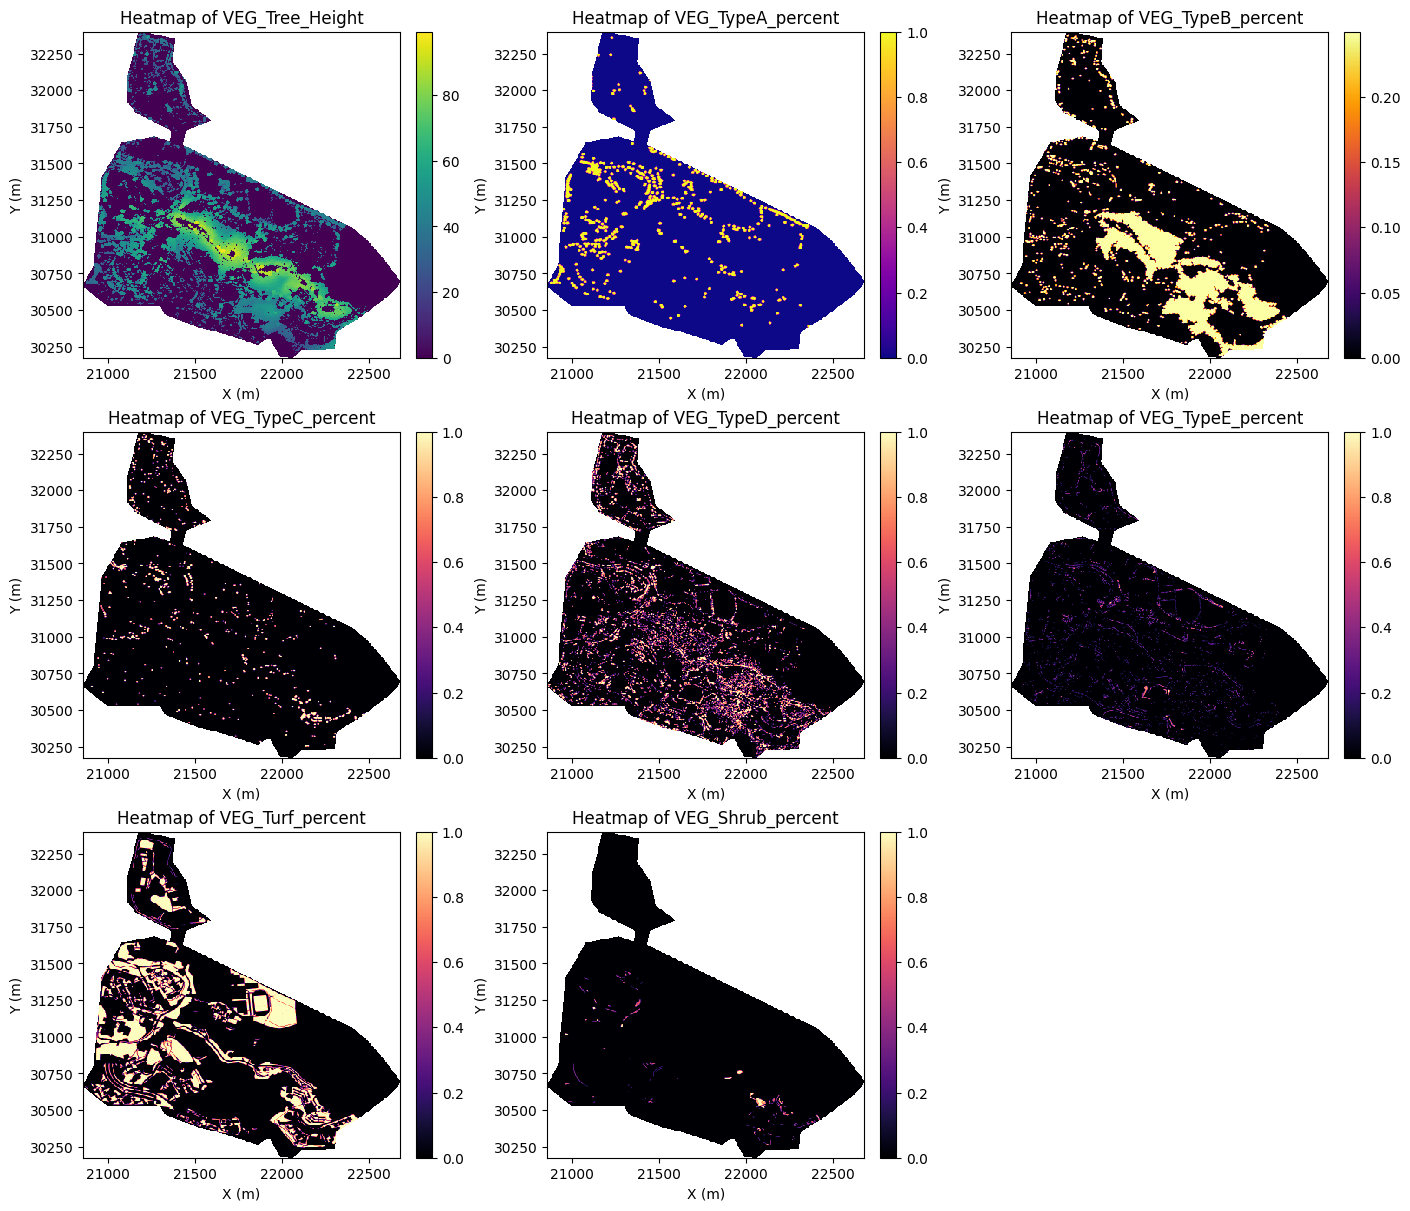

Plot saved to your_filepath_here\features_02


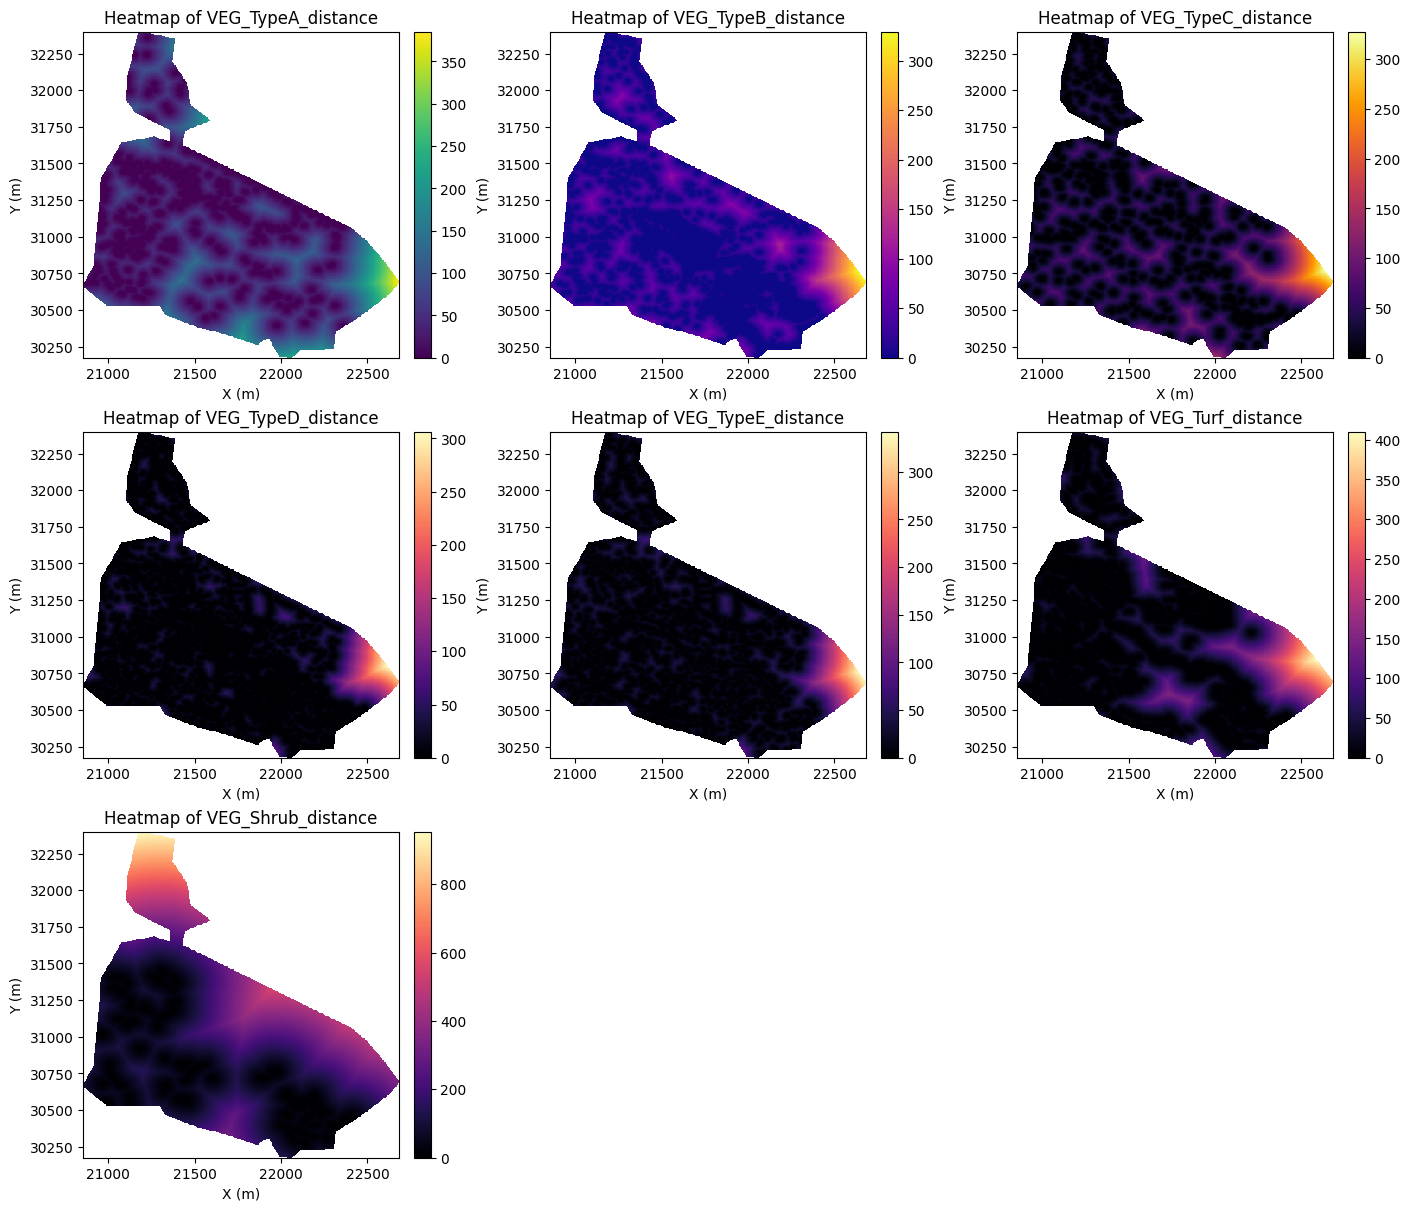

Plot saved to your_filepath_here\features_03


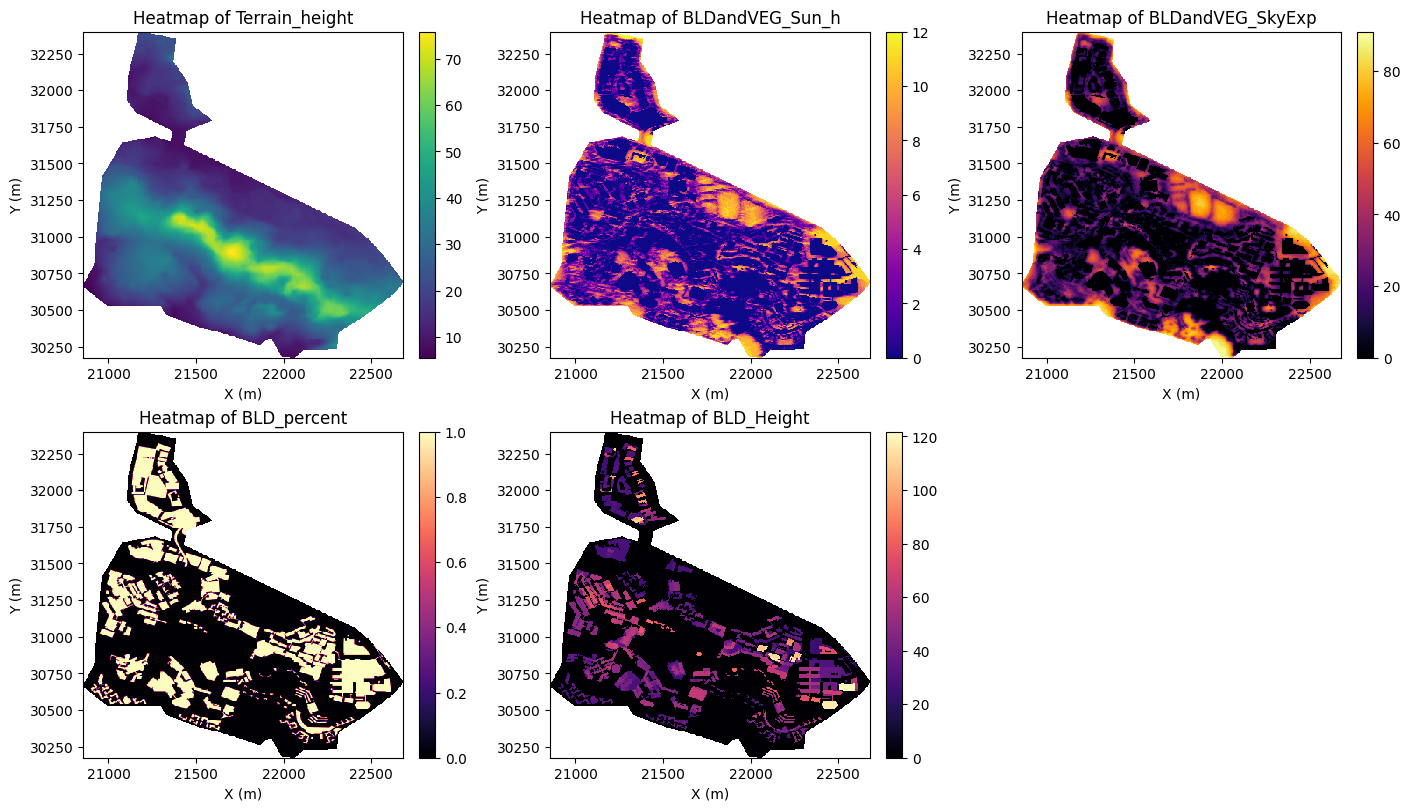

Plot saved to your_filepath_here\features_04


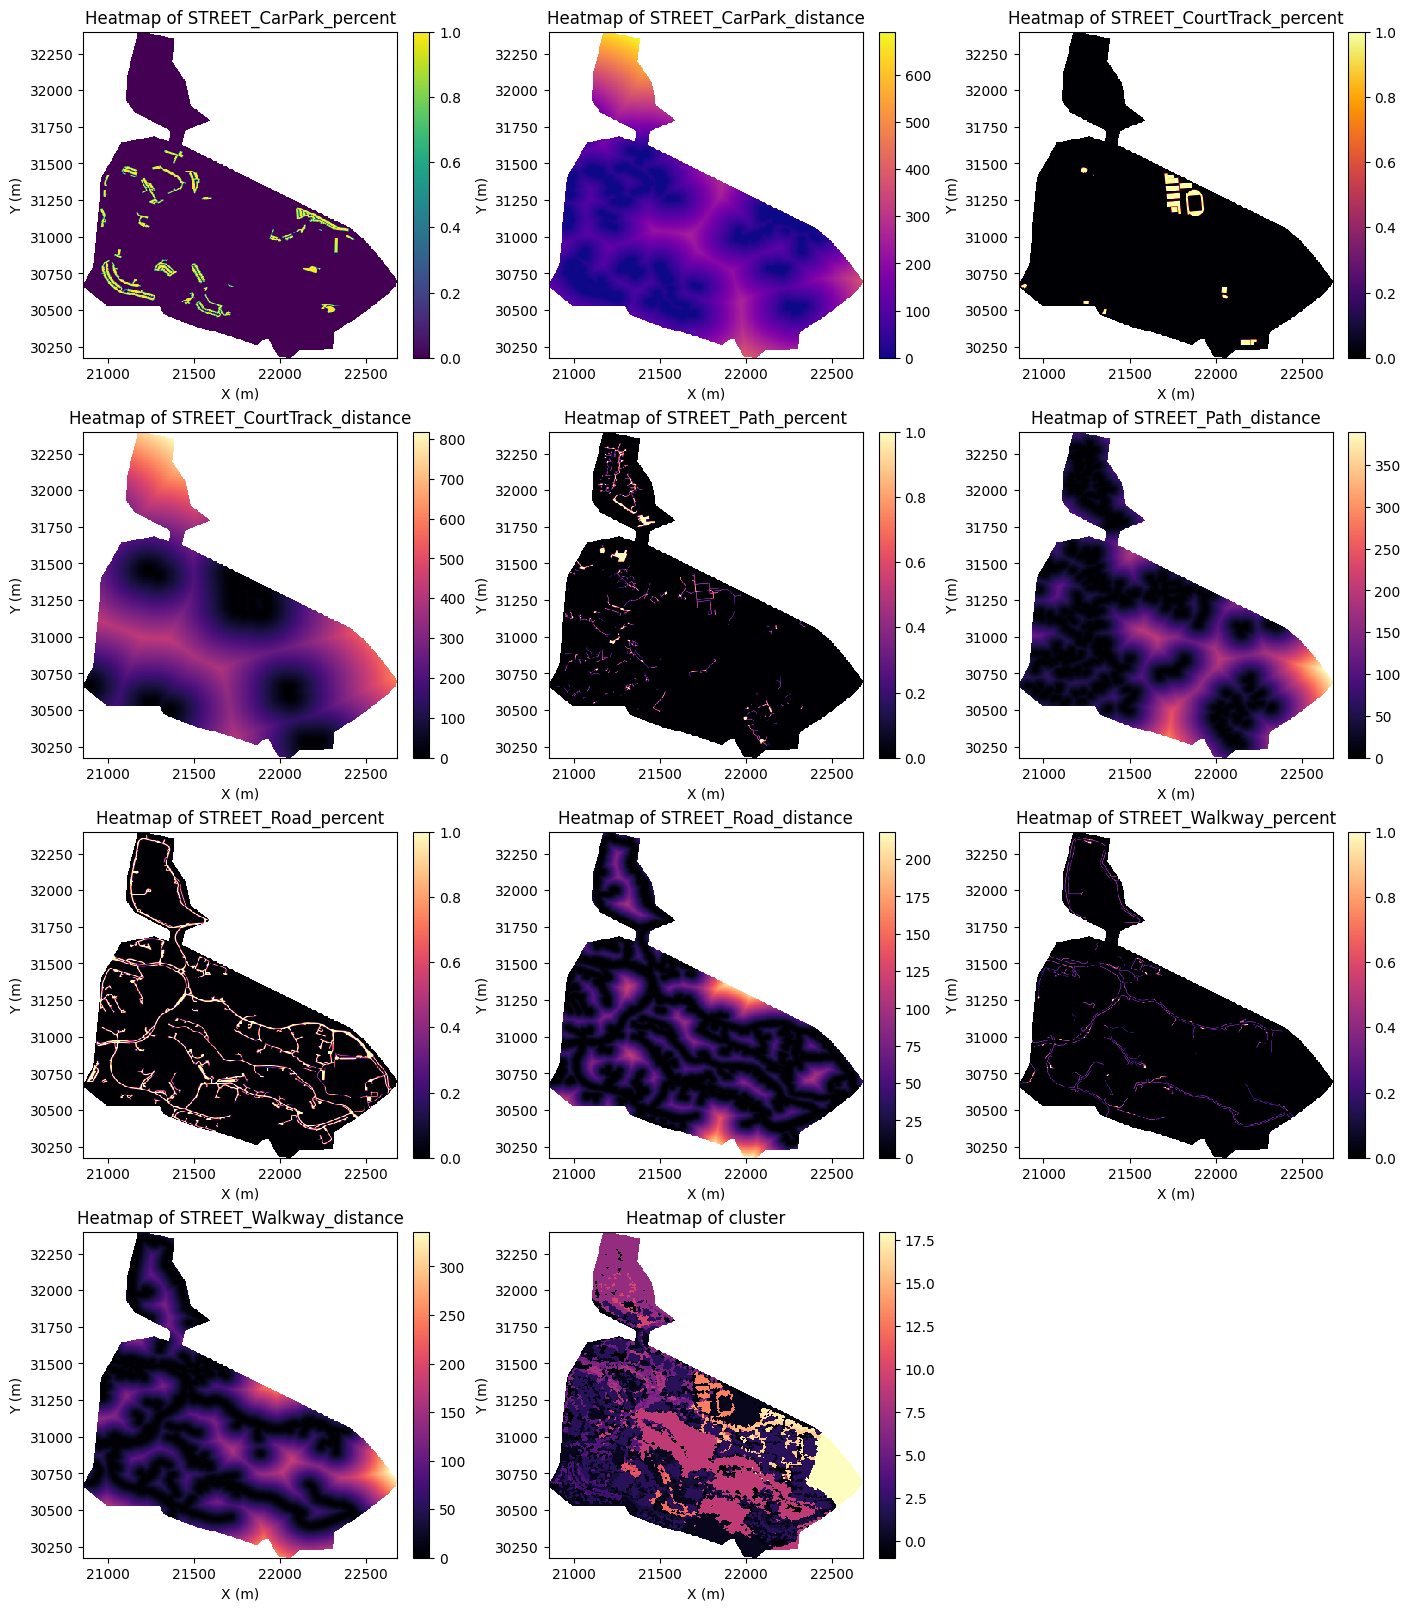

In [19]:
feature_df = griddf
display(feature_df.head(5))
#features = distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances
feature_df.to_csv('test.csv')


terrain_features  = ['Terrain_height']
sky_features      = ['BLDandVEG_Sun_h', 'BLDandVEG_SkyExp']
bld_features      = ['BLD_percent', 'BLD_Height']
veg_percentage    = ['VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent']
veg_distances     = ['VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']
distance_features = ['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance']


feature_list = veg_percentage
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3, filepath_dir, 'features_01')
feature_df.to_csv('test.csv')

feature_list = veg_distances
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_02')

feature_list = terrain_features + sky_features + bld_features
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_03')

feature_list = distance_features + ['cluster']
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_04')

# feature_list = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad']
# cmap_list = ['viridis', 'plasma', 'inferno', 'magma']
# plot_heatmaps(feature_df, feature_list, cmap_list)

### Regression Kriging

In [29]:
# display(wsdf.head(5))
# df_times = df.copy()
# display(df_times.head(5))

values_to_drop = ['WS60', 'WS11', 'WS06', 'WS47', 'WS65', 'WS37', 'WS56', 'WS77', 'WS43', 'WS45', 'WS44', 'WS17', 'WS16']
values_to_drop_nr = [1, 9, 10, 19, 22, 28, 30, 33, 34, 35, 37, 32, 39]
# Drop the Weatherstations that have problematic data (empty data)
wsdf_cleaned = wsdf[~wsdf['Shortname'].isin(values_to_drop)]

# Drop the same indecies based on the wsdf cleaned Shortnames
df_times_cleaned = df_times.drop(values_to_drop_nr)
df_times_cleaned = df_times_cleaned.drop(columns=['index', 'Lat', 'Lon']) # I dont know how they ended up here, but they are not relevant.

last_index = wsdf.index[-1]
wsdf_cleaned = wsdf_cleaned.drop(last_index, errors='ignore')
display(wsdf_cleaned.head(5))
display(df_times_cleaned.head(5))

# wsdf_cleaned.to_csv('wsdf_cleaned.csv') #weather station data

X             Y Shortname  STREET_CarPark_percent  \
0  21090.276586  31446.608220      WS76                  0.3502   
2  21066.835035  31298.582162      WS62                  0.0000   
3  21039.589703  31247.486168      WS03                  0.0000   
4  21036.026652  31177.437049      WS75                  0.0000   
5  20997.720468  31187.013787      WS73                  0.0000   

   STREET_CarPark_distance  STREET_CourtTrack_percent  \
0                 0.137760                        0.0   
2                64.375464                        0.0   
3                54.972402                        0.0   
4                54.784100                        0.0   
5                22.527222                        0.0   

   STREET_CourtTrack_distance  STREET_Path_percent  STREET_Path_distance  \
0                  121.954487                  0.0             21.895744   
2                  205.803563                  0.0             91.251008   
3                  261.295745                  0.0             89.120003   
4                  319.048430                  0.0             20.861799   
5                  334.881645                  0.0             17.386149   

   STREET_Road_percent  ...  BLD_Height  Terrain_height  VEG_TypeA_distance  \
0               0.3112  ...    0.000000       24.996696            0.000000   
2               0.0000  ...    0.000000       37.547951           63.634202   
3               0.4718  ...   38.268177       37.041089           47.455893   
4               0.1048  ...   18.182040       35.557390           33.157814   
5               0.0000  ...   47.106069       31.828376           30.091218   

   VEG_TypeB_distance  VEG_TypeC_distance  VEG_TypeD_distance  \
0            2.669324            6.903046            0.335490   
2           44.561607           39.762896           29.811385   
3           47.535387           42.237677            4.683099   
4           25.756954           27.684181           20.637183   
5            7.495829            8.532869           15.485037   

   VEG_TypeE_distance  VEG_Turf_distance  VEG_Shrub_distance  cluster  
0            4.882615           0.000000           44.523452        6  
2           28.945288           0.000000            1.238752        0  
3            3.951791           2.416046           49.869348        2  
4           26.025345          24.544936           56.712319        2  
5           16.339393          16.487221           83.550346        2  

[5 rows x 34 columns]

2024-03-19 19:07:00+08:00  2024-03-22 22:23:00+08:00  \
0                      32.11                      33.69   
2                      30.89                      32.29   
3                      31.83                      34.52   
4                      31.43                      33.64   
5                      32.18                      33.82   

   2024-02-22 13:46:00+08:00  2024-02-20 11:41:00+08:00  \
0                      26.66                      27.01   
2                      26.48                      26.86   
3                      27.23                      27.47   
4                      26.86                      27.20   
5                      26.51                      26.89   

   2024-03-13 14:11:00+08:00  2024-03-04 13:55:00+08:00  \
0                      26.38                      26.71   
2                      26.37                      26.61   
3                      26.93                      26.94   
4                      26.62                      26.61   
5                      26.34                      26.56   

   2024-03-21 20:12:00+08:00  2024-02-28 13:38:00+08:00  \
0                      32.24                      27.18   
2                      31.32                      27.04   
3                      33.30                      27.65   
4                      33.18                      27.32   
5                      32.36                      27.00   

   2024-03-06 19:57:00+08:00  2024-03-07 13:04:00+08:00  ...  \
0                      33.69                      26.67  ...   
2                      30.40                      26.61  ...   
3                      31.46                      26.80  ...   
4                      32.77                      26.71  ...   
5                      34.42                      26.58  ...   

   2024-03-22 19:29:00+08:00  2024-03-07 14:05:00+08:00  \
0                      31.86                      26.65   
2                      30.52                      26.56   
3                      31.99                      26.84   
4                      31.35                      26.72   
5                      31.82                      26.48   

   2024-03-06 18:16:00+08:00  2024-02-29 11:17:00+08:00  \
0                      30.95                      26.78   
2                      28.90                      26.65   
3                      29.35                      27.46   
4                      29.19                      27.02   
5                      30.23                      26.67   

   2024-03-21 14:10:00+08:00  2024-03-13 17:28:00+08:00  \
0                      27.33                      28.84   
2                      27.16                      28.25   
3                      27.77                      28.58   
4                      27.50                      28.58   
5                      27.24                      29.14   

   2024-03-05 14:56:00+08:00  2024-02-28 14:06:00+08:00  \
0                      25.35                      27.17   
2                      25.80                      26.94   
3                      25.71                      27.59   
4                      25.30                      27.24   
5                      25.35                      27.02   

   2024-02-29 11:16:00+08:00  2024-03-06 20:06:00+08:00  
0                      26.79                      33.93  
2                      26.67                      30.87  
3                      27.46                      31.72  
4                      27.03                      33.42  
5                      26.71                      33.23  

[5 rows x 108 columns]

In [ ]:
import re
### Select features for model
measure = "AirTemperature"

def safe_float_conversion(x):
    try:
        return float(x)
    except ValueError:
        return x  
    
# display(wsdf.describe())
# # df = df.drop('Shortname', axis=1)
# display(df.describe())
print(features)



df_ws = wsdf_cleaned.copy()
df_times_inter = df_times_cleaned.copy()

df_ws = df_ws.applymap(safe_float_conversion)
df_times_inter = df_times_inter.applymap(safe_float_conversion)

p = df_ws[features]
pprint(df_ws.columns)
#display(p)


#times = ['2024-03-19 19:07:00+08:00','2024-03-22 22:23:00+08:00', '2024-02-22 13:46:00+08:00']
#times = ['2024-03-19 19:07:00+08:00']
print(times)
grid = griddf
grid = grid.applymap(safe_float_conversion)


### CONSTRUCT
target_p = grid[features]
target_x = np.array(list(zip(grid.X, grid.Y)))


#closest_points.to_csv('closest_points.csv') #griddata
df_ws.to_csv('df_ws.csv') #weather station data
df_times_inter.to_csv('df_times_inter.csv') 

feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])
print("=" * 40)

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['#linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

### List of month names


results_df = pd.DataFrame(columns=['time', 'X', 'Y', 'value'])


print('----------- STARTING: 0 out of ' + str(len(times)))
index = 0
debug: bool = True
for k in variogram_models:
    model = RandomForestRegressor(n_estimators=15, random_state=random_state)

    scores_mths = []
    for hours in times:
        print(hours)

        #dt = mth #.to_pydatetime() 
        # filename = hours # dt.strftime('%Y-%m-%d_%H-%M-%S_%z')
        filename = re.sub(r'[ :+]', '_', hours)
        filename = re.sub(r'-{2,}', '_', filename)  # Clean up any double hyphens if necessary



        x = np.array(list(zip(df_ws.X, df_ws.Y)), dtype=float)
        # print(x)
        if hours in df_times_inter.columns:
            #print(x)
            target = df_times_inter[hours].dropna()
            x = x[:len(target)]  # Ensure x and target have the same length

            # Convert target to numpy array
            target = np.array(target)
            print(f"Processing: Column {hours} does exist in the dataframe.")
        else:
            print(f"Column {hours} does not exist in the dataframe.")
            print("=" * 40)
            continue

        # target = np.array(df[mth])

        
        m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)


        #print(p)

        print(f"Length of p: {len(p)}, Length of x: {len(x)}, Length of target: {len(target)}")

        

        m_rk.fit(p, x, target)
        result = m_rk.predict(target_p, target_x)
        resultdf = grid
        resultdf[measure] = result

        ### Append results to the results_df
        temp_df = resultdf[['id', 'X', 'Y']].copy()
        temp_df['time'] = hours
        temp_df['value'] = result
        results_df = pd.concat([results_df, temp_df])

        ### Plot map (uncomment and adjust vmin, vmax and ticks if needed)
        minval = 22.5
        maxval = 40

        # Ensure output directory exists
        if not os.path.exists(dirOut + today):
            os.makedirs(dirOut + today)

        # ------------------------- PLOT START
        if (debug):
            plt.figure(figsize=(10, 7))

            # Scatter plot with custom color map and color range
            sc = plt.scatter(resultdf['X'], resultdf['Y'], c=resultdf[measure], cmap='seismic', marker='s', s=1, vmin=minval, vmax=maxval)
            plt.title('Scatter plot of ' + measure + ' (' + filename + ')')

            # Colorbar with custom ticks
            # cbar = plt.colorbar(sc)
            # ticks = [14.0, 16.5, 19.0, 21.5, 24.0, 26.5, 29.0, 31.5]
            # cbar.set_ticks(ticks)
            # cbar.set_ticklabels(ticks)

            # Axis limits
            ax = plt.gca()
            ax.set_xlim(20800, 22500)
            ax.set_ylim(30200, 31700)
k
            # Save CSV and optional PNG
            
            # plt.savefig(dirOut + today + '/' + measure + filename + '.png', bbox_inches='tight')

            plt.show()
        # ------------------------- PLOT END
        resultdf.to_csv(dirOut + today + '/' + measure + filename + '.csv')

        ### Extract feature importances (uncomment to display feature importances)
        feature_importance_df[hours] = m_rk.regression_model.feature_importances_
        print(f'{index} out of ' + str(len(times)))
        index = index + 1
        print("=" * 40)
# Make a csv, that holds the time, gridcells and values append new results

if not os.path.exists(dirOut + today):
    os.makedirs(dirOut + today)

results_df = results_df.reset_index(drop=True)
results_df.to_csv(dirOut + today + '/all_results.csv', index=False)
display(results_df)
        # featuredf = pd.DataFrame(list(zip(m_rk.regression_model.feature_names_in_, m_rk.regression_model.feature_importances_)), columns =['FeatureName', 'FeatureImportance'])
        # display(featuredf.sort_values(by=['FeatureImportance'], ascending=False))

### Feature Importance

FeatureName  2024-03-19 19:07:00+08:00  \
0       STREET_CarPark_percent                   0.007046   
1      STREET_CarPark_distance                   0.010928   
2    STREET_CourtTrack_percent                   0.000000   
3   STREET_CourtTrack_distance                   0.039300   
4          STREET_Path_percent                   0.000000   
5         STREET_Path_distance                   0.062329   
6          STREET_Road_percent                   0.000295   
7         STREET_Road_distance                   0.043466   
8       STREET_Walkway_percent                   0.000207   
9      STREET_Walkway_distance                   0.017502   
10             BLDandVEG_Sun_h                   0.001043   
11            BLDandVEG_SkyExp                   0.007372   
12             VEG_Tree_Height                   0.001327   
13           VEG_TypeA_percent                   0.000000   
14           VEG_TypeB_percent                   0.083451   
15           VEG_TypeC_percent                   0.000000   
16           VEG_TypeD_percent                   0.029793   
17           VEG_TypeE_percent                   0.030509   
18            VEG_Turf_percent                   0.018235   
19           VEG_Shrub_percent                   0.000359   
20                 BLD_percent                   0.111963   
21                  BLD_Height                   0.018403   
22              Terrain_height                   0.029334   
23          VEG_TypeA_distance                   0.084338   
24          VEG_TypeB_distance                   0.143516   
25          VEG_TypeC_distance                   0.017667   
26          VEG_TypeD_distance                   0.065367   
27          VEG_TypeE_distance                   0.081288   
28           VEG_Turf_distance                   0.025464   
29          VEG_Shrub_distance                   0.058062   
30                     cluster                   0.011433   

    2024-03-22 22:23:00+08:00  2024-02-22 13:46:00+08:00  \
0                    0.009711               5.927331e-03   
1                    0.012489               8.668798e-03   
2                    0.000000               1.835949e-14   
3                    0.009577               1.869105e-01   
4                    0.000620               0.000000e+00   
5                    0.083033               1.242465e-02   
6                    0.000176               1.676623e-02   
7                    0.130572               1.576151e-01   
8                    0.000236               5.010671e-02   
9                    0.014176               3.423771e-02   
10                   0.020393               9.069787e-03   
11                   0.020219               8.879679e-04   
12                   0.000263               1.410744e-02   
13                   0.002218               8.714881e-03   
14                   0.004893               8.237344e-03   
15                   0.000000               0.000000e+00   
16                   0.000481               2.489150e-02   
17                   0.005541               4.816341e-03   
18                   0.024999               1.859979e-02   
19                   0.000004               8.612390e-05   
20                   0.102939               4.025499e-03   
21                   0.011026               1.610362e-02   
22                   0.013948               1.885061e-02   
23                   0.002544               4.076911e-02   
24                   0.031512               9.419028e-02   
25                   0.282473               9.335797e-02   
26                   0.003507               3.384246e-02   
27                   0.014118               4.339726e-02   
28                   0.152605               4.700847e-02   
29                   0.033282               1.972851e-02   
30                   0.012444               2.665801e-02   

    2024-02-20 11:41:00+08:00  2024-03-13 14:11:00+08:00  \
0                    0.003565                   0.000085   
1                    0.00

C:\Users\gottk\AppData\Local\Temp\ipykernel_24120\1948427600.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_importance_df['mean'] = feature_importance_df[numeric_cols].mean(axis=1)


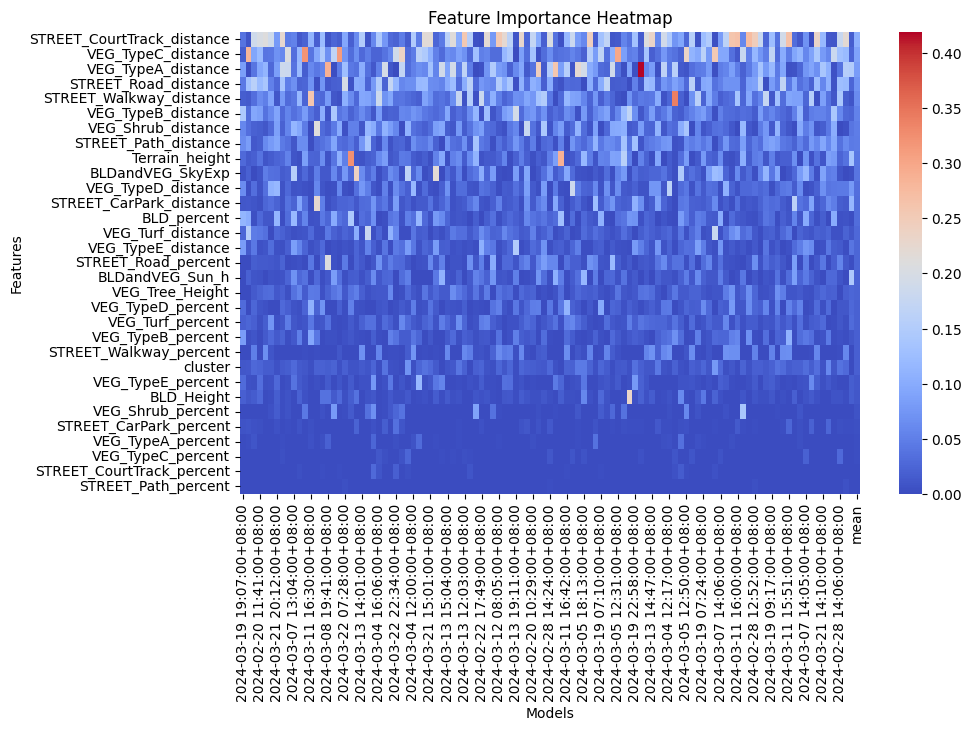

['STREET_CourtTrack_distance', 'VEG_TypeC_distance', 'VEG_TypeA_distance', 'STREET_Road_distance', 'STREET_Walkway_distance', 'VEG_TypeB_distance', 'VEG_Shrub_distance', 'STREET_Path_distance', 'Terrain_height', 'BLDandVEG_SkyExp', 'VEG_TypeD_distance', 'STREET_CarPark_distance', 'BLD_percent', 'VEG_Turf_distance', 'VEG_TypeE_distance', 'STREET_Road_percent']


In [38]:
display(feature_importance_df)
if 'FeatureName' not in feature_importance_df.columns:
    feature_importance_df.reset_index(inplace=True)

# Calculate the mean of only numeric columns
numeric_cols = feature_importance_df.select_dtypes(include='number').columns
feature_importance_df['mean'] = feature_importance_df[numeric_cols].mean(axis=1)

# Sort and set index for plotting
feature_plotheatmap = feature_importance_df.sort_values(by='mean', ascending=False).set_index('FeatureName')


plt.figure(figsize=(10, 6))
sns.heatmap(feature_plotheatmap, annot=False, cmap='coolwarm')
plt.title('Feature Importance Heatmap')
plt.xlabel('Models')
plt.ylabel('Features')
plt.show()

# plt.savefig(dirRP + today + '/' + 'FeatureMap' + '_' + measure + mth + '.png', bbox_inches='tight')

#select features based on threshhold
treshhold = 0.025
update_feature_selection = feature_plotheatmap[feature_plotheatmap['mean'] > treshhold].index.tolist()
print(update_feature_selection)